In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

### Load dsets

In [3]:
stim_sp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/enc_test_512.npy')
stim_pred = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/pred_test_512.npy')
stim_y = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/y_test_512.npy')
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/resp_test_512.npy')

In [4]:
stim_err = stim_y - stim_pred
stim_spec = np.concatenate((stim_sp, stim_err), axis=1)

In [5]:
np.shape(stim_spec), np.shape(stim_resp)

((5706, 544), (5706, 214, 32))

In [6]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=512, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [7]:
nsegbins = 32

In [8]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [9]:
np.shape(stim_mne), np.shape(resp_mne)

((5706, 544), (5706, 214))

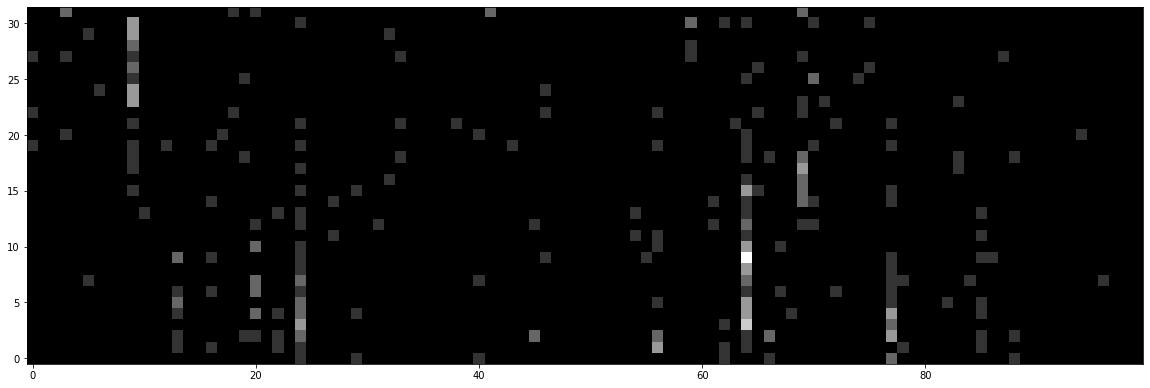

In [10]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [11]:
len_units = np.shape(resp_mne)[1]

In [12]:
units_to_process = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process.npy'))

In [13]:
exp_path = '/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_512/error_mne/'        

In [14]:
# obtain all preprocessed datas

%matplotlib inline
sdim = 256
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.149006
    2       0    0.145517
    3       0    0.144103
    4       0    0.142799
    5       0    0.141613
    6       0    0.142650
    7       1    0.142287
    8       2    0.139012
    9       0    0.139776
   10       1    0.138745
   11       0    0.137540
   12       0    0.138631
   13       1    0.139698
   14       2    0.138781
   15       3    0.137735
   16       4    0.137150
   17       0    0.137229
   18       1    0.136562
   19       0    0.137432
   20       1    0.137572
   21       2    0.139972
   22       3    0.141235
   23       4    0.141242
   24       5    0.140232
   25       6    0.140709
   26       7    0.139875
   27       8    0.139088
   28       9    0.139580
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.185458
    2       0    0.177408
    3       0    0.167853
    4       0    0.171097
    5       1    0.168498
    6       2    0.164400
    7       0    0.166005
    8       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.130856
    2       0    0.128405
    3       0    0.126340
    4       0    0.125950
    5       0    0.124370
    6       0    0.122418
    7       0    0.120249
    8       0    0.120203
    9       0    0.118870
   10       0    0.117657
   11       0    0.118069
   12       1    0.117710
   13       2    0.117626
   14       0    0.118233
   15       1    0.118394
   16       2    0.117831
   17       3    0.117300
   18       0    0.119123
   19       1    0.122087
   20       2    0.120001
   21       3    0.119137
   22       4    0.120207
   23       5    0.120450
   24       6    0.120173
   25       7    0.120808
   26       8    0.120821
   27       9    0.119899
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.101817
    2       0    0.099076
    3       0    0.097659
    4       0    0.097965
    5       1    0.097678
    6       2    0.096885
    7       0    0.095402
    8       0    0.095176
    9       0    0.094826
   10       

   23       2    0.178767
   24       3    0.178208
   25       4    0.178913
   26       5    0.178471
   27       6    0.178650
   28       7    0.178271
   29       8    0.178807
   30       9    0.178671
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.214508
    2       0    0.208057
    3       0    0.205527
    4       0    0.207476
    5       1    0.204077
    6       0    0.198726
    7       0    0.199161
    8       1    0.198396
    9       0    0.201519
   10       1    0.199929
   11       2    0.198798
   12       3    0.195912
   13       0    0.195550
   14       0    0.196255
   15       1    0.195721
   16       2    0.195958
   17       3    0.196378
   18       4    0.195611
   19       5    0.195322
   20       0    0.196033
   21       1    0.195000
   22       0    0.195325
   23       1    0.196139
   24       2    0.195775
   25       3    0.196188
   26       4    0.195585
   27       5    0.195841
   28       6    0.196077
   29       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.069298
    2       0    0.070001
    3       0    0.066060
    4       0    0.065256
    5       0    0.063532
    6       0    0.062206
    7       0    0.061857
    8       0    0.061380
    9       0    0.061573
   10       1    0.061039
   11       0    0.061322
   12       1    0.061239
   13       2    0.061980
   14       3    0.061603
   15       4    0.061108
   16       5    0.060863
   17       0    0.060457
   18       0    0.060500
   19       1    0.060540
   20       2    0.060386
   21       0    0.060468
   22       1    0.060690
   23       2    0.060736
   24       3    0.061038
   25       4    0.061746
   26       5    0.061630
   27       6    0.061679
   28       7    0.061524
   29       8    0.061692
   30       9    0.061700
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.070095
    2       0    0.067784
    3       0    0.067322
    4       0    0.067613
    5       1    0.067099
    6       0    0.065949
    7       

   31       2    0.106581
   32       3    0.107054
   33       4    0.107109
   34       5    0.106798
   35       6    0.106901
   36       7    0.106766
   37       8    0.106623
   38       9    0.106516
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.123997
    2       0    0.123850
    3       0    0.123363
    4       0    0.120815
    5       0    0.117804
    6       0    0.118560
    7       1    0.118091
    8       2    0.115936
    9       0    0.115461
   10       0    0.115277
   11       0    0.115479
   12       1    0.115510
   13       2    0.114795
   14       0    0.113966
   15       0    0.113974
   16       1    0.113281
   17       0    0.112587
   18       0    0.113136
   19       1    0.112749
   20       2    0.113492
   21       3    0.113897
   22       4    0.113535
   23       5    0.113097
   24       6    0.113316
   25       7    0.112956
   26       8    0.113968
   27       9    0.113445
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.162563
    2       0    0.162476
    3       0    0.156087
    4       0    0.153413
    5       0    0.151883
    6       0    0.149200
    7       0    0.147763
    8       0    0.147356
    9       0    0.147160
   10       0    0.146939
   11       0    0.146597
   12       0    0.146329
   13       0    0.146527
   14       1    0.146683
   15       2    0.146339
   16       3    0.145582
   17       0    0.145759
   18       1    0.145532
   19       0    0.145377
   20       0    0.145752
   21       1    0.146010
   22       2    0.145509
   23       3    0.145568
   24       4    0.145431
   25       5    0.145750
   26       6    0.145557
   27       7    0.147115
   28       8    0.147413
   29       9    0.148609
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.166289
    2       0    0.163538
    3       0    0.161994
    4       0    0.159284
    5       0    0.157868
    6       0    0.157099
    7       0    0.156296
    8       0    0.155466
    9       0    0.154436
   10       0    0.155387
   11       1    0.155034
   12       2    0.154430
   13       0    0.153364
   14       0    0.153123
   15       0    0.153964
   16       1    0.154407
   17       2    0.154453
   18       3    0.154968
   19       4    0.156660
   20       5    0.156124
   21       6    0.156219
   22       7    0.156520
   23       8    0.155960
   24       9    0.155745
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.159229
    2       0    0.159584
    3       0    0.153215
    4       0    0.151184
    5       0    0.149771
    6       0    0.147359
    7       0    0.146593
    8       0    0.146137
    9       0    0.146121
   10       0    0.146001
   11       0    0.146170
   12       1    0.146747
   13       2    0.146310
   14       3    0.145415
   15       0    0.145259
   16       0    0.145328
   17       1    0.145366
   18       2    0.145871
   19       3    0.145864
   20       4    0.145975
   21       5    0.146083
   22       6    0.146148
   23       7    0.146216
   24       8    0.145620
   25       9    0.145309
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.171002
    2       0    0.168817
    3       0    0.164713
    4       0    0.164693
    5       0    0.160733
    6       0    0.160029
    7       0    0.159174
    8       0    0.159077
    9       0    0.159913
   10       1    0.158832
   11       0    0.158468
   12       0    0.157448
   13       0    0.158133
   14       1    0.157640
   15       2    0.157050
   16       0    0.157457
   17       1    0.157124
   18       2    0.157663
   19       3    0.157335
   20       4    0.156940
   21       0    0.156414
   22       0    0.157159
   23       1    0.157180
   24       2    0.156831
   25       3    0.157293
   26       4    0.157141
   27       5    0.156789
   28       6    0.156868
   29       7    0.156860
   30       8    0.157440
   31       9    0.157389
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.299300
    2       0    0.295115
    3       0    0.289298
    4       0    0.282515
    5       0    0.279685
    6       

    1       0    0.038791
    2       0    0.038178
    3       0    0.037097
    4       0    0.036812
    5       0    0.036404
    6       0    0.036198
    7       0    0.035873
    8       0    0.035816
    9       0    0.035617
   10       0    0.035592
   11       0    0.035830
   12       1    0.035599
   13       2    0.035304
   14       0    0.035182
   15       0    0.035853
   16       1    0.035717
   17       2    0.035240
   18       3    0.035146
   19       0    0.035036
   20       0    0.035286
   21       1    0.035246
   22       2    0.035109
   23       3    0.035392
   24       4    0.035337
   25       5    0.035218
   26       6    0.035101
   27       7    0.035283
   28       8    0.035312
   29       9    0.035649
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.051220
    2       0    0.049775
    3       0    0.048446
    4       0    0.048701
    5       1    0.048530
    6       2    0.047776
    7       0    0.047949
    8       

   15       0    0.607096
   16       0    0.607777
   17       1    0.608596
   18       2    0.608916
   19       3    0.608286
   20       4    0.608796
   21       5    0.608612
   22       6    0.608098
   23       7    0.608211
   24       8    0.608072
   25       9    0.607829
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.626716
    2       0    0.621754
    3       0    0.617786
    4       0    0.617273
    5       0    0.614244
    6       0    0.614729
    7       1    0.613863
    8       0    0.612952
    9       0    0.611960
   10       0    0.610993
   11       0    0.610072
   12       0    0.610266
   13       1    0.609748
   14       0    0.608930
   15       0    0.608925
   16       0    0.608561
   17       0    0.608184
   18       0    0.608084
   19       0    0.607649
   20       0    0.607321
   21       0    0.606787
   22       0    0.606752
   23       0    0.606081
   24       0    0.605702
   25       0    0.605450
   26       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.636133
    2       0    0.626675
    3       0    0.623538
    4       0    0.620799
    5       0    0.620448
    6       0    0.617879
    7       0    0.616356
    8       0    0.614866
    9       0    0.614217
   10       0    0.613209
   11       0    0.611995
   12       0    0.610095
   13       0    0.608799
   14       0    0.608503
   15       0    0.607495
   16       0    0.606899
   17       0    0.606958
   18       1    0.607748
   19       2    0.607280
   20       3    0.607239
   21       4    0.606713
   22       0    0.605464
   23       0    0.605114
   24       0    0.604372
   25       0    0.603832
   26       0    0.603815
   27       0    0.603780
   28       0    0.604070
   29       1    0.603804
   30       2    0.603394
   31       0    0.603342
   32       0    0.603113
   33       0    0.602908
   34       0    0.602863
   35       0    0.602861
   36       0    0.602707
   37       0    0.602512
   38       0    0.602544
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.631140
    2       0    0.619071
    3       0    0.615964
    4       0    0.611253
    5       0    0.610634
    6       0    0.610220
    7       0    0.605304
    8       0    0.603465
    9       0    0.601474
   10       0    0.601280
   11       0    0.600080
   12       0    0.600364
   13       1    0.600185
   14       2    0.598271
   15       0    0.596254
   16       0    0.596182
   17       0    0.595241
   18       0    0.594329
   19       0    0.593926
   20       0    0.593747
   21       0    0.593734
   22       0    0.593577
   23       0    0.593318
   24       0    0.593214
   25       0    0.593340
   26       1    0.593408
   27       2    0.593320
   28       3    0.593751
   29       4    0.594103
   30       5    0.594958
   31       6    0.596791
   32       7    0.597257
   33       8    0.598170
   34       9    0.598178
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.637280
    2       0    0.627766
    3       0    0.625531
    4       0    0.620554
    5       0    0.615722
    6       0    0.612738
    7       0    0.612823
    8       1    0.613887
    9       2    0.611490
   10       0    0.609226
   11       0    0.608006
   12       0    0.606901
   13       0    0.605062
   14       0    0.605001
   15       0    0.604176
   16       0    0.603598
   17       0    0.603986
   18       1    0.603595
   19       0    0.603335
   20       0    0.603459
   21       1    0.603012
   22       0    0.603476
   23       1    0.603367
   24       2    0.603289
   25       3    0.602690
   26       0    0.602695
   27       1    0.601870
   28       0    0.601803
   29       0    0.602085
   30       1    0.602060
   31       2    0.601852
   32       3    0.601655
   33       0    0.601771
   34       1    0.601608
   35       0    0.601403
   36       0    0.601320
   37       0    0.601479
   38       1    0.601391
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.150427
    2       0    0.143236
    3       0    0.139773
    4       0    0.137963
    5       0    0.136431
    6       0    0.135245
    7       0    0.134645
    8       0    0.133262
    9       0    0.133421
   10       1    0.133234
   11       0    0.132804
   12       0    0.132699
   13       0    0.131798
   14       0    0.131893
   15       1    0.131696
   16       0    0.133041
   17       1    0.133485
   18       2    0.133311
   19       3    0.132071
   20       4    0.131817
   21       5    0.132049
   22       6    0.132330
   23       7    0.131620
   24       0    0.131783
   25       1    0.131587
   26       0    0.131267
   27       0    0.131223
   28       0    0.131456
   29       1    0.131173
   30       0    0.130850
   31       0    0.130888
   32       1    0.131077
   33       2    0.130899
   34       3    0.131367
   35       4    0.131595
   36       5    0.131210
   37       6    0.131384
   38       7    0.131338
   39       

   33       4    0.287627
   34       5    0.287874
   35       6    0.288116
   36       7    0.288126
   37       8    0.287306
   38       9    0.287336
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.446729
    2       0    0.441216
    3       0    0.439306
    4       0    0.439289
    5       0    0.439559
    6       1    0.438973
    7       0    0.438745
    8       0    0.436038
    9       0    0.432613
   10       0    0.431266
   11       0    0.430693
   12       0    0.430107
   13       0    0.430122
   14       1    0.430477
   15       2    0.429928
   16       0    0.428648
   17       0    0.427991
   18       0    0.428215
   19       1    0.427992
   20       2    0.427343
   21       0    0.426941
   22       0    0.427353
   23       1    0.427257
   24       2    0.427154
   25       3    0.428432
   26       4    0.428598
   27       5    0.427910
   28       6    0.427928
   29       7    0.426932
   30       0    0.427035
   31       

   37       9    0.229603
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.247670
    2       0    0.243064
    3       0    0.241179
    4       0    0.240636
    5       0    0.236505
    6       0    0.234733
    7       0    0.234532
    8       0    0.233203
    9       0    0.232088
   10       0    0.231320
   11       0    0.230642
   12       0    0.228805
   13       0    0.227971
   14       0    0.227287
   15       0    0.227124
   16       0    0.226937
   17       0    0.226787
   18       0    0.225974
   19       0    0.226224
   20       1    0.226493
   21       2    0.226832
   22       3    0.226513
   23       4    0.225596
   24       0    0.226150
   25       1    0.225954
   26       2    0.225694
   27       3    0.225665
   28       4    0.225752
   29       5    0.225697
   30       6    0.225600
   31       7    0.225525
   32       0    0.225425
   33       0    0.225505
   34       1    0.225506
   35       2    0.225620
   36       

   21       1    0.088784
   22       2    0.088764
   23       3    0.088555
   24       0    0.088154
   25       0    0.088131
   26       0    0.088063
   27       0    0.088036
   28       0    0.088270
   29       1    0.089012
   30       2    0.089283
   31       3    0.089913
   32       4    0.090299
   33       5    0.090575
   34       6    0.090876
   35       7    0.090629
   36       8    0.090783
   37       9    0.090753
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.104086
    2       0    0.101551
    3       0    0.097940
    4       0    0.098703
    5       1    0.097874
    6       0    0.094633
    7       0    0.093308
    8       0    0.094325
    9       1    0.094158
   10       2    0.091870
   11       0    0.091307
   12       0    0.091501
   13       1    0.091654
   14       2    0.091797
   15       3    0.091132
   16       0    0.090626
   17       0    0.090973
   18       1    0.090801
   19       2    0.090761
   20       

    8       0    0.139438
    9       0    0.139592
   10       1    0.138605
   11       0    0.138812
   12       1    0.138968
   13       2    0.138700
   14       3    0.138080
   15       0    0.138359
   16       1    0.138359
   17       2    0.140098
   18       3    0.139300
   19       4    0.139604
   20       5    0.140465
   21       6    0.140134
   22       7    0.139773
   23       8    0.140162
   24       9    0.140054
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.151714
    2       0    0.150408
    3       0    0.148071
    4       0    0.146400
    5       0    0.146541
    6       1    0.146206
    7       0    0.145999
    8       0    0.145380
    9       0    0.145173
   10       0    0.144876
   11       0    0.144718
   12       0    0.144568
   13       0    0.144268
   14       0    0.144134
   15       0    0.144105
   16       0    0.144171
   17       1    0.144221
   18       2    0.144852
   19       3    0.145264
   20       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.050140
    2       0    0.048605
    3       0    0.046258
    4       0    0.046141
    5       0    0.046238
    6       1    0.044723
    7       0    0.044895
    8       1    0.044953
    9       2    0.045083
   10       3    0.045192
   11       4    0.044566
   12       0    0.044000
   13       0    0.044173
   14       1    0.044220
   15       2    0.043817
   16       0    0.043602
   17       0    0.043559
   18       0    0.043849
   19       1    0.043825
   20       2    0.043654
   21       3    0.043391
   22       0    0.043698
   23       1    0.043479
   24       2    0.043454
   25       3    0.043780
   26       4    0.043808
   27       5    0.043426
   28       6    0.043592
   29       7    0.043761
   30       8    0.044101
   31       9    0.043952
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.298348
    2       0    0.292042
    3       0    0.288626
    4       0    0.287924
    5       0    0.286529
    6       

    8       0    0.231665
    9       0    0.230843
   10       0    0.229628
   11       0    0.229872
   12       1    0.228435
   13       0    0.228624
   14       1    0.227817
   15       0    0.227836
   16       1    0.227066
   17       0    0.227023
   18       0    0.226776
   19       0    0.226531
   20       0    0.226756
   21       1    0.226861
   22       2    0.226396
   23       0    0.226439
   24       1    0.226310
   25       0    0.226121
   26       0    0.226181
   27       1    0.226166
   28       2    0.226113
   29       0    0.226271
   30       1    0.225997
   31       0    0.226050
   32       1    0.225943
   33       0    0.226367
   34       1    0.226337
   35       2    0.226270
   36       3    0.226652
   37       4    0.226404
   38       5    0.226323
   39       6    0.226593
   40       7    0.226435
   41       8    0.226514
   42       9    0.226884
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.253033
    2       

    7       0    0.067069
    8       0    0.067239
    9       1    0.067899
   10       2    0.067096
   11       3    0.066306
   12       0    0.066759
   13       1    0.066868
   14       2    0.065623
   15       0    0.065892
   16       1    0.065748
   17       2    0.065313
   18       0    0.065762
   19       1    0.065797
   20       2    0.065349
   21       3    0.065454
   22       4    0.066125
   23       5    0.065580
   24       6    0.065133
   25       0    0.065250
   26       1    0.064955
   27       0    0.065472
   28       1    0.066068
   29       2    0.065305
   30       3    0.065428
   31       4    0.065032
   32       5    0.065302
   33       6    0.065180
   34       7    0.065438
   35       8    0.065698
   36       9    0.065496
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.078062
    2       0    0.074032
    3       0    0.072667
    4       0    0.072253
    5       0    0.070656
    6       0    0.070079
    7       

   17       0    0.109576
   18       1    0.109614
   19       2    0.110126
   20       3    0.109790
   21       4    0.109678
   22       5    0.109632
   23       6    0.109299
   24       7    0.109242
   25       8    0.109475
   26       9    0.109246
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.124925
    2       0    0.119655
    3       0    0.117273
    4       0    0.117993
    5       1    0.118327
    6       2    0.114854
    7       0    0.113897
    8       0    0.114034
    9       1    0.112870
   10       0    0.110626
   11       0    0.110248
   12       0    0.110385
   13       1    0.110625
   14       2    0.110939
   15       3    0.111734
   16       4    0.112263
   17       5    0.111892
   18       6    0.112492
   19       7    0.112442
   20       8    0.112126
   21       9    0.112578
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.145693
    2       0    0.137075
    3       0    0.134135
    4       

   15       0    0.579538
   16       0    0.579142
   17       0    0.578135
   18       0    0.578379
   19       1    0.578050
   20       0    0.577549
   21       0    0.577558
   22       1    0.577550
   23       2    0.577527
   24       0    0.577177
   25       0    0.576695
   26       0    0.576716
   27       1    0.576034
   28       0    0.575811
   29       0    0.576063
   30       1    0.576191
   31       2    0.576392
   32       3    0.576729
   33       4    0.576529
   34       5    0.576112
   35       6    0.575982
   36       7    0.576143
   37       8    0.575990
   38       9    0.576041
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.603858
    2       0    0.600101
    3       0    0.596995
    4       0    0.592801
    5       0    0.590693
    6       0    0.588299
    7       0    0.587410
    8       0    0.587505
    9       1    0.581723
   10       0    0.581990
   11       1    0.581260
   12       0    0.578956
   13       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.205501
    2       0    0.203513
    3       0    0.201140
    4       0    0.199684
    5       0    0.197365
    6       0    0.196643
    7       0    0.196976
    8       1    0.195342
    9       0    0.194167
   10       0    0.194130
   11       0    0.193728
   12       0    0.194162
   13       1    0.193624
   14       0    0.191940
   15       0    0.192375
   16       1    0.191705
   17       0    0.192168
   18       1    0.191415
   19       0    0.191832
   20       1    0.191824
   21       2    0.192462
   22       3    0.191827
   23       4    0.191785
   24       5    0.191174
   25       0    0.191266
   26       1    0.190852
   27       0    0.191263
   28       1    0.191006
   29       2    0.191569
   30       3    0.191536
   31       4    0.192294
   32       5    0.192386
   33       6    0.191688
   34       7    0.191452
   35       8    0.191648
   36       9    0.191425
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.215807
    2       0    0.212965
    3       0    0.209635
    4       0    0.209043
    5       0    0.207045
    6       0    0.207127
    7       1    0.205587
    8       0    0.205506
    9       0    0.203853
   10       0    0.202820
   11       0    0.202337
   12       0    0.202743
   13       1    0.201142
   14       0    0.200450
   15       0    0.201482
   16       1    0.200467
   17       2    0.200520
   18       3    0.200823
   19       4    0.200197
   20       0    0.200463
   21       1    0.199783
   22       0    0.200509
   23       1    0.200011
   24       2    0.199789
   25       3    0.200074
   26       4    0.199806
   27       5    0.200210
   28       6    0.200043
   29       7    0.199939
   30       8    0.200346
   31       9    0.200714
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.198771
    2       0    0.197032
    3       0    0.196081
    4       0    0.194939
    5       0    0.195090
    6       1    0.194775
    7       0    0.192509
    8       0    0.191353
    9       0    0.190472
   10       0    0.189807
   11       0    0.189220
   12       0    0.188315
   13       0    0.188160
   14       0    0.189274
   15       1    0.189002
   16       2    0.188365
   17       3    0.188423
   18       4    0.187637
   19       0    0.187567
   20       0    0.187365
   21       0    0.187333
   22       0    0.187135
   23       0    0.187149
   24       1    0.187888
   25       2    0.187541
   26       3    0.187330
   27       4    0.187375
   28       5    0.187252
   29       6    0.187143
   30       7    0.187243
   31       8    0.187322
   32       9    0.187200
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.200362
    2       0    0.197882
    3       0    0.197090
    4       0    0.195913
    5       0    0.195150
    6       0    0.194090
    7       0    0.194107
    8       1    0.193520
    9       0    0.193548
   10       1    0.192018
   11       0    0.191479
   12       0    0.189882
   13       0    0.189822
   14       0    0.189395
   15       0    0.189909
   16       1    0.190717
   17       2    0.191500
   18       3    0.190747
   19       4    0.190467
   20       5    0.189642
   21       6    0.189262
   22       0    0.189672
   23       1    0.189891
   24       2    0.189248
   25       0    0.188989
   26       0    0.188529
   27       0    0.188444
   28       0    0.188829
   29       1    0.188644
   30       2    0.188647
   31       3    0.188354
   32       0    0.188548
   33       1    0.188431
   34       2    0.188198
   35       0    0.188456
   36       1    0.188761
   37       2    0.188471
   38       3    0.188189
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.169786
    2       0    0.164449
    3       0    0.157104
    4       0    0.154988
    5       0    0.155532
    6       1    0.153908
    7       0    0.152046
    8       0    0.153011
    9       1    0.151955
   10       0    0.151866
   11       0    0.151403
   12       0    0.151555
   13       1    0.150517
   14       0    0.150939
   15       1    0.150444
   16       0    0.150793
   17       1    0.150069
   18       0    0.150561
   19       1    0.150282
   20       2    0.150581
   21       3    0.149712
   22       0    0.150125
   23       1    0.150238
   24       2    0.150117
   25       3    0.150886
   26       4    0.151902
   27       5    0.151799
   28       6    0.152874
   29       7    0.152685
   30       8    0.151797
   31       9    0.152388
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.162859
    2       0    0.158047
    3       0    0.153303
    4       0    0.152409
    5       0    0.149866
    6       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.673346
    2       0    0.667860
    3       0    0.666652
    4       0    0.663905
    5       0    0.660063
    6       0    0.659358
    7       0    0.658448
    8       0    0.657814
    9       0    0.657386
   10       0    0.657189
   11       0    0.656665
   12       0    0.656229
   13       0    0.655610
   14       0    0.655705
   15       1    0.655528
   16       0    0.655052
   17       0    0.654855
   18       0    0.654599
   19       0    0.653786
   20       0    0.653476
   21       0    0.653290
   22       0    0.653093
   23       0    0.652804
   24       0    0.652667
   25       0    0.652660
   26       0    0.652747
   27       1    0.652625
   28       0    0.652606
   29       0    0.653121
   30       1    0.653538
   31       2    0.653215
   32       3    0.652716
   33       4    0.652533
   34       0    0.652586
   35       1    0.652733
   36       2    0.652976
   37       3    0.652790
   38       4    0.652789
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.671441
    2       0    0.666512
    3       0    0.665071
    4       0    0.663389
    5       0    0.659000
    6       0    0.657228
    7       0    0.656867
    8       0    0.655598
    9       0    0.654268
   10       0    0.652994
   11       0    0.652231
   12       0    0.651911
   13       0    0.651805
   14       0    0.651220
   15       0    0.650648
   16       0    0.650855
   17       1    0.650654
   18       2    0.650133
   19       0    0.650053
   20       0    0.649934
   21       0    0.650116
   22       1    0.650051
   23       2    0.649984
   24       3    0.649501
   25       0    0.649336
   26       0    0.649560
   27       1    0.650370
   28       2    0.650234
   29       3    0.650232
   30       4    0.649820
   31       5    0.649668
   32       6    0.649545
   33       7    0.649753
   34       8    0.649697
   35       9    0.649855
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.671450
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.675861
    2       0    0.669953
    3       0    0.668504
    4       0    0.666155
    5       0    0.663826
    6       0    0.663354
    7       0    0.661145
    8       0    0.660707
    9       0    0.659680
   10       0    0.659777
   11       1    0.659626
   12       0    0.659621
   13       0    0.658472
   14       0    0.657528
   15       0    0.657389
   16       0    0.657166
   17       0    0.656928
   18       0    0.656029
   19       0    0.655744
   20       0    0.655695
   21       0    0.655957
   22       1    0.656179
   23       2    0.655509
   24       0    0.655778
   25       1    0.655577
   26       2    0.655982
   27       3    0.655782
   28       4    0.655953
   29       5    0.655918
   30       6    0.655291
   31       0    0.655271
   32       0    0.655396
   33       1    0.655147
   34       0    0.655007
   35       0    0.655071
   36       1    0.655223
   37       2    0.655125
   38       3    0.655149
   39       

   19       0    0.587813
   20       0    0.587072
   21       0    0.586037
   22       0    0.585994
   23       0    0.585554
   24       0    0.585249
   25       0    0.585304
   26       1    0.585627
   27       2    0.585390
   28       3    0.584989
   29       0    0.584438
   30       0    0.584186
   31       0    0.584137
   32       0    0.583963
   33       0    0.583956
   34       0    0.583775
   35       0    0.583547
   36       0    0.583539
   37       0    0.583540
   38       1    0.583909
   39       2    0.583931
   40       3    0.584059
   41       4    0.583749
   42       5    0.583607
   43       6    0.583564
   44       7    0.583617
   45       8    0.583528
   46       0    0.583412
   47       0    0.583732
   48       1    0.583840
   49       2    0.583759
   50       3    0.583752
   51       4    0.583500
   52       5    0.583535
   53       6    0.583497
   54       7    0.583473
   55       8    0.583509
   56       9    0.583480
minimum of t

   20       3    0.135486
   21       4    0.136140
   22       5    0.136383
   23       6    0.136012
   24       7    0.136592
   25       8    0.136869
   26       9    0.136310
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.134673
    2       0    0.133265
    3       0    0.133600
    4       1    0.130114
    5       0    0.129906
    6       0    0.129899
    7       0    0.129084
    8       0    0.128629
    9       0    0.128064
   10       0    0.128114
   11       1    0.128331
   12       2    0.127897
   13       0    0.127327
   14       0    0.127775
   15       1    0.128606
   16       2    0.128133
   17       3    0.127471
   18       4    0.127315
   19       0    0.127325
   20       1    0.128510
   21       2    0.128840
   22       3    0.128131
   23       4    0.128009
   24       5    0.127946
   25       6    0.127770
   26       7    0.127797
   27       8    0.128665
   28       9    0.128262
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.189817
    2       0    0.184330
    3       0    0.182910
    4       0    0.181766
    5       0    0.180439
    6       0    0.178262
    7       0    0.178113
    8       0    0.177336
    9       0    0.176551
   10       0    0.176310
   11       0    0.175924
   12       0    0.175724
   13       0    0.175206
   14       0    0.174789
   15       0    0.175302
   16       1    0.174837
   17       2    0.174498
   18       0    0.175135
   19       1    0.174897
   20       2    0.174561
   21       3    0.174711
   22       4    0.173936
   23       0    0.174155
   24       1    0.174551
   25       2    0.174253
   26       3    0.174548
   27       4    0.174573
   28       5    0.174642
   29       6    0.174038
   30       7    0.173985
   31       8    0.174441
   32       9    0.174289
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.190661
    2       0    0.187491
    3       0    0.186019
    4       0    0.185212
    5       0    0.184157
    6       0    0.184133
    7       0    0.182724
    8       0    0.182298
    9       0    0.181866
   10       0    0.181658
   11       0    0.180819
   12       0    0.180620
   13       0    0.180692
   14       1    0.179990
   15       0    0.179745
   16       0    0.179388
   17       0    0.180074
   18       1    0.179895
   19       2    0.179022
   20       0    0.178642
   21       0    0.178479
   22       0    0.178397
   23       0    0.178623
   24       1    0.178852
   25       2    0.178609
   26       3    0.179020
   27       4    0.179343
   28       5    0.178972
   29       6    0.178707
   30       7    0.178911
   31       8    0.178613
   32       9    0.178370
   33       0    0.178368
   34       0    0.178510
   35       1    0.178289
   36       0    0.178177
   37       0    0.178363
   38       1    0.178367
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.197093
    2       0    0.195217
    3       0    0.192705
    4       0    0.191451
    5       0    0.190243
    6       0    0.191364
    7       1    0.190029
    8       0    0.187971
    9       0    0.188333
   10       1    0.188626
   11       2    0.187658
   12       0    0.186797
   13       0    0.185583
   14       0    0.186040
   15       1    0.185754
   16       2    0.184874
   17       0    0.185969
   18       1    0.186045
   19       2    0.184288
   20       0    0.184482
   21       1    0.184353
   22       2    0.184502
   23       3    0.183464
   24       0    0.183300
   25       0    0.183990
   26       1    0.183747
   27       2    0.183822
   28       3    0.183839
   29       4    0.183561
   30       5    0.183710
   31       6    0.184002
   32       7    0.183273
   33       0    0.183354
   34       1    0.184291
   35       2    0.184378
   36       3    0.184589
   37       4    0.184470
   38       5    0.183742
   39       

   13       0    0.446886
   14       0    0.446683
   15       0    0.446472
   16       0    0.446074
   17       0    0.446612
   18       1    0.447097
   19       2    0.446329
   20       3    0.445423
   21       0    0.445395
   22       0    0.445333
   23       0    0.444926
   24       0    0.444830
   25       0    0.444808
   26       0    0.445012
   27       1    0.444769
   28       0    0.444359
   29       0    0.444294
   30       0    0.444278
   31       0    0.444072
   32       0    0.444122
   33       1    0.444241
   34       2    0.444101
   35       3    0.444224
   36       4    0.444384
   37       5    0.444494
   38       6    0.444303
   39       7    0.444118
   40       8    0.444329
   41       9    0.444197
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.470458
    2       0    0.460843
    3       0    0.453933
    4       0    0.450703
    5       0    0.446805
    6       0    0.442938
    7       0    0.442025
    8       

   33       2    0.636170
   34       0    0.636321
   35       1    0.636713
   36       2    0.636719
   37       3    0.636514
   38       4    0.637070
   39       5    0.637153
   40       6    0.636730
   41       7    0.636781
   42       8    0.636624
   43       9    0.636522
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.647762
    2       0    0.639667
    3       0    0.637432
    4       0    0.637693
    5       1    0.633774
    6       0    0.632092
    7       0    0.633030
    8       1    0.633654
    9       2    0.631216
   10       0    0.629798
   11       0    0.628192
   12       0    0.627000
   13       0    0.626767
   14       0    0.626678
   15       0    0.626500
   16       0    0.625377
   17       0    0.625762
   18       1    0.625427
   19       2    0.625004
   20       0    0.625022
   21       1    0.625354
   22       2    0.624679
   23       0    0.624368
   24       0    0.625139
   25       1    0.624816
   26       2    0.624146
   27       0    0.624567
   28       1    0.624400
   29       2    0.623767
   30       0    0.623890
   31       1    0.624135
   32       2    0.624052
   33       3    0.624120
   34       4    0.623933
   35       5    0.624011
   36       6    0.624188
   37       7    0.623884
   38       8    0.624199
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.541898
    2       0    0.532983
    3       0    0.527779
    4       0    0.523960
    5       0    0.524487
    6       1    0.519880
    7       0    0.519160
    8       0    0.515641
    9       0    0.515331
   10       0    0.512609
   11       0    0.509541
   12       0    0.507859
   13       0    0.507478
   14       0    0.506934
   15       0    0.505890
   16       0    0.505692
   17       0    0.505684
   18       0    0.504836
   19       0    0.504579
   20       0    0.504314
   21       0    0.504233
   22       0    0.503988
   23       0    0.504090
   24       1    0.504216
   25       2    0.503964
   26       0    0.503786
   27       0    0.503830
   28       1    0.503881
   29       2    0.503804
   30       3    0.503650
   31       0    0.503631
   32       0    0.503881
   33       1    0.503838
   34       2    0.503589
   35       0    0.503555
   36       0    0.503601
   37       1    0.503563
   38       2    0.503701
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.543693
    2       0    0.532728
    3       0    0.526014
    4       0    0.524574
    5       0    0.524525
    6       0    0.516718
    7       0    0.515361
    8       0    0.512891
    9       0    0.511668
   10       0    0.511468
   11       0    0.510095
   12       0    0.508498
   13       0    0.507193
   14       0    0.508162
   15       1    0.507258
   16       2    0.506255
   17       0    0.505747
   18       0    0.505776
   19       1    0.505300
   20       0    0.505061
   21       0    0.505378
   22       1    0.505019
   23       0    0.504498
   24       0    0.503422
   25       0    0.502991
   26       0    0.503247
   27       1    0.502598
   28       0    0.502590
   29       0    0.502953
   30       1    0.502655
   31       2    0.501979
   32       0    0.502139
   33       1    0.502468
   34       2    0.502361
   35       3    0.502124
   36       4    0.502683
   37       5    0.502727
   38       6    0.502191
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.535761
    2       0    0.524218
    3       0    0.518947
    4       0    0.516360
    5       0    0.513587
    6       0    0.511360
    7       0    0.511064
    8       0    0.506860
    9       0    0.504851
   10       0    0.503187
   11       0    0.502311
   12       0    0.502035
   13       0    0.501828
   14       0    0.501593
   15       0    0.501465
   16       0    0.500032
   17       0    0.499232
   18       0    0.498251
   19       0    0.498768
   20       1    0.498993
   21       2    0.498003
   22       0    0.497891
   23       0    0.497750
   24       0    0.497930
   25       1    0.498097
   26       2    0.497888
   27       3    0.497935
   28       4    0.498466
   29       5    0.498940
   30       6    0.498852
   31       7    0.498445
   32       8    0.498432
   33       9    0.498731
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.414427
    2       0    0.403411
    3       0    0.399344
    4       0    0.396896
    5       0    0.393717
    6       0    0.392637
    7       0    0.392189
    8       0    0.391225
    9       0    0.389543
   10       0    0.389078
   11       0    0.388441
   12       0    0.388403
   13       0    0.388124
   14       0    0.387779
   15       0    0.386656
   16       0    0.386505
   17       0    0.385473
   18       0    0.385543
   19       1    0.385972
   20       2    0.385766
   21       3    0.385607
   22       4    0.385643
   23       5    0.385349
   24       0    0.385085
   25       0    0.385085
   26       1    0.384914
   27       0    0.385106
   28       1    0.385510
   29       2    0.385116
   30       3    0.384548
   31       0    0.384657
   32       1    0.385495
   33       2    0.386023
   34       3    0.385853
   35       4    0.385912
   36       5    0.385812
   37       6    0.385601
   38       7    0.385563
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.421795
    2       0    0.408809
    3       0    0.405719
    4       0    0.403731
    5       0    0.400224
    6       0    0.399632
    7       0    0.398378
    8       0    0.396706
    9       0    0.396285
   10       0    0.395922
   11       0    0.395790
   12       0    0.394640
   13       0    0.392797
   14       0    0.392777
   15       0    0.392717
   16       0    0.392339
   17       0    0.392749
   18       1    0.392833
   19       2    0.392180
   20       0    0.391919
   21       0    0.391710
   22       0    0.391617
   23       0    0.391493
   24       0    0.391461
   25       0    0.391252
   26       0    0.391748
   27       1    0.391411
   28       2    0.391897
   29       3    0.391974
   30       4    0.391243
   31       0    0.391278
   32       1    0.391459
   33       2    0.391366
   34       3    0.391355
   35       4    0.391936
   36       5    0.391819
   37       6    0.391541
   38       7    0.391712
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.416459
    2       0    0.405525
    3       0    0.401408
    4       0    0.398447
    5       0    0.395582
    6       0    0.393209
    7       0    0.391813
    8       0    0.390747
    9       0    0.389534
   10       0    0.388702
   11       0    0.388005
   12       0    0.387769
   13       0    0.386586
   14       0    0.386196
   15       0    0.385001
   16       0    0.385323
   17       1    0.384630
   18       0    0.384351
   19       0    0.383759
   20       0    0.384374
   21       1    0.384128
   22       2    0.383435
   23       0    0.383570
   24       1    0.383357
   25       0    0.383519
   26       1    0.383442
   27       2    0.383067
   28       0    0.383250
   29       1    0.383063
   30       0    0.382701
   31       0    0.384415
   32       1    0.384792
   33       2    0.383176
   34       3    0.382942
   35       4    0.383099
   36       5    0.382652
   37       0    0.382835
   38       1    0.382664
   39       

   26       5    0.181437
   27       6    0.181014
   28       7    0.180746
   29       0    0.180963
   30       1    0.180842
   31       2    0.181374
   32       3    0.181562
   33       4    0.182192
   34       5    0.182230
   35       6    0.183006
   36       7    0.183070
   37       8    0.184071
   38       9    0.183978
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.200284
    2       0    0.198045
    3       0    0.188465
    4       0    0.187504
    5       0    0.186350
    6       0    0.187184
    7       1    0.184470
    8       0    0.185872
    9       1    0.184169
   10       0    0.184818
   11       1    0.182120
   12       0    0.183320
   13       1    0.182992
   14       2    0.181837
   15       0    0.181848
   16       1    0.182823
   17       2    0.182064
   18       3    0.180968
   19       0    0.181368
   20       1    0.180950
   21       0    0.179917
   22       0    0.180783
   23       1    0.180118
   24       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.488581
    2       0    0.476728
    3       0    0.470449
    4       0    0.466702
    5       0    0.462688
    6       0    0.460096
    7       0    0.458766
    8       0    0.458330
    9       0    0.455093
   10       0    0.454399
   11       0    0.453233
   12       0    0.452887
   13       0    0.452429
   14       0    0.450508
   15       0    0.450713
   16       1    0.449975
   17       0    0.448709
   18       0    0.448929
   19       1    0.448296
   20       0    0.448062
   21       0    0.448368
   22       1    0.448496
   23       2    0.448951
   24       3    0.448544
   25       4    0.448516
   26       5    0.448261
   27       6    0.448840
   28       7    0.448945
   29       8    0.448071
   30       9    0.448020
   31       0    0.447644
   32       0    0.448010
   33       1    0.447781
   34       2    0.447639
   35       0    0.447522
   36       0    0.447304
   37       0    0.447411
   38       1    0.447684
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.494270
    2       0    0.491454
    3       0    0.478617
    4       0    0.475690
    5       0    0.474768
    6       0    0.471368
    7       0    0.469861
    8       0    0.467122
    9       0    0.465583
   10       0    0.463289
   11       0    0.461701
   12       0    0.461172
   13       0    0.460385
   14       0    0.459619
   15       0    0.459517
   16       0    0.458692
   17       0    0.457544
   18       0    0.457890
   19       1    0.457645
   20       2    0.457706
   21       3    0.458233
   22       4    0.457865
   23       5    0.457965
   24       6    0.458162
   25       7    0.457836
   26       8    0.457711
   27       9    0.457807
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.489297
    2       0    0.480530
    3       0    0.471871
    4       0    0.468483
    5       0    0.466915
    6       0    0.468030
    7       1    0.458544
    8       0    0.455694
    9       0    0.454354
   10       0    0.453469
   11       0    0.452102
   12       0    0.451638
   13       0    0.452338
   14       1    0.451915
   15       2    0.450729
   16       0    0.448747
   17       0    0.448086
   18       0    0.448257
   19       1    0.448045
   20       0    0.447825
   21       0    0.447246
   22       0    0.447420
   23       1    0.447343
   24       2    0.447272
   25       3    0.447267
   26       4    0.447127
   27       0    0.446444
   28       0    0.445708
   29       0    0.446105
   30       1    0.446146
   31       2    0.445957
   32       3    0.446207
   33       4    0.446732
   34       5    0.446847
   35       6    0.446985
   36       7    0.447452
   37       8    0.447176
   38       9    0.446796
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.502619
    2       0    0.488480
    3       0    0.477153
    4       0    0.473275
    5       0    0.473157
    6       0    0.472847
    7       0    0.468865
    8       0    0.465476
    9       0    0.463745
   10       0    0.462734
   11       0    0.463043
   12       1    0.462564
   13       0    0.460937
   14       0    0.460549
   15       0    0.460021
   16       0    0.459508
   17       0    0.459175
   18       0    0.459225
   19       1    0.457699
   20       0    0.455592
   21       0    0.454811
   22       0    0.455365
   23       1    0.455194
   24       2    0.455274
   25       3    0.455700
   26       4    0.455252
   27       5    0.455035
   28       6    0.455623
   29       7    0.455591
   30       8    0.454749
   31       0    0.454543
   32       0    0.454385
   33       0    0.453931
   34       0    0.453767
   35       0    0.453971
   36       1    0.453823
   37       2    0.453331
   38       0    0.453695
   39       

   20       2    0.094319
   21       3    0.094508
   22       4    0.095742
   23       5    0.095007
   24       6    0.094543
   25       7    0.095288
   26       8    0.094852
   27       9    0.095225
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.381690
    2       0    0.374771
    3       0    0.368840
    4       0    0.369749
    5       1    0.367148
    6       0    0.364197
    7       0    0.362762
    8       0    0.364186
    9       1    0.363223
   10       2    0.362699
   11       0    0.359659
   12       0    0.358396
   13       0    0.359541
   14       1    0.358821
   15       2    0.357042
   16       0    0.357903
   17       1    0.357553
   18       2    0.358780
   19       3    0.357767
   20       4    0.356816
   21       0    0.355964
   22       0    0.356678
   23       1    0.356281
   24       2    0.357179
   25       3    0.356650
   26       4    0.357479
   27       5    0.357605
   28       6    0.357302
   29       

    8       1    0.164979
    9       2    0.162864
   10       3    0.160141
   11       0    0.158404
   12       0    0.158651
   13       1    0.158750
   14       2    0.157766
   15       0    0.157148
   16       0    0.157499
   17       1    0.157444
   18       2    0.158821
   19       3    0.159354
   20       4    0.156783
   21       0    0.157078
   22       1    0.157738
   23       2    0.158340
   24       3    0.158404
   25       4    0.158297
   26       5    0.159624
   27       6    0.159447
   28       7    0.159449
   29       8    0.158933
   30       9    0.159131
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.161438
    2       0    0.158551
    3       0    0.158817
    4       1    0.159068
    5       2    0.154972
    6       0    0.153213
    7       0    0.153137
    8       0    0.151531
    9       0    0.150961
   10       0    0.151028
   11       1    0.150299
   12       0    0.150264
   13       0    0.150109
   14       

    4       0    0.244711
    5       0    0.241017
    6       0    0.241190
    7       1    0.240262
    8       0    0.239691
    9       0    0.237334
   10       0    0.236535
   11       0    0.236073
   12       0    0.236701
   13       1    0.238017
   14       2    0.238321
   15       3    0.239270
   16       4    0.240530
   17       5    0.240929
   18       6    0.239754
   19       7    0.238299
   20       8    0.238051
   21       9    0.237939
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.243901
    2       0    0.242656
    3       0    0.243887
    4       1    0.241227
    5       0    0.238476
    6       0    0.235960
    7       0    0.232329
    8       0    0.232584
    9       1    0.233263
   10       2    0.234449
   11       3    0.233330
   12       4    0.233164
   13       5    0.231373
   14       0    0.230785
   15       0    0.231039
   16       1    0.231416
   17       2    0.228151
   18       0    0.229209
   19       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.221271
    2       0    0.216526
    3       0    0.213738
    4       0    0.211586
    5       0    0.211371
    6       0    0.210474
    7       0    0.211079
    8       1    0.210669
    9       2    0.210181
   10       0    0.209139
   11       0    0.209012
   12       0    0.208218
   13       0    0.207440
   14       0    0.207332
   15       0    0.207126
   16       0    0.206597
   17       0    0.207477
   18       1    0.208238
   19       2    0.207328
   20       3    0.206899
   21       4    0.206536
   22       0    0.206428
   23       0    0.206464
   24       1    0.205955
   25       0    0.205770
   26       0    0.205935
   27       1    0.206949
   28       2    0.207316
   29       3    0.207175
   30       4    0.206244
   31       5    0.205695
   32       0    0.205548
   33       0    0.205823
   34       1    0.206209
   35       2    0.206491
   36       3    0.206270
   37       4    0.206071
   38       5    0.205878
   39       

   22       0    0.474042
   23       0    0.473978
   24       0    0.474116
   25       1    0.474650
   26       2    0.474459
   27       3    0.474038
   28       4    0.474449
   29       5    0.474472
   30       6    0.475047
   31       7    0.475837
   32       8    0.476331
   33       9    0.476191
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.082103
    2       0    0.081159
    3       0    0.077641
    4       0    0.076848
    5       0    0.075668
    6       0    0.074620
    7       0    0.074694
    8       1    0.075435
    9       2    0.075230
   10       3    0.074399
   11       0    0.073260
   12       0    0.072898
   13       0    0.072619
   14       0    0.072482
   15       0    0.072244
   16       0    0.072562
   17       1    0.073034
   18       2    0.072524
   19       3    0.072395
   20       4    0.072590
   21       5    0.072668
   22       6    0.072573
   23       7    0.072788
   24       8    0.072660
   25       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.098874
    2       0    0.095571
    3       0    0.093631
    4       0    0.095090
    5       1    0.092995
    6       0    0.091338
    7       0    0.091927
    8       1    0.091072
    9       0    0.091006
   10       0    0.091171
   11       1    0.089705
   12       0    0.089217
   13       0    0.090506
   14       1    0.090635
   15       2    0.089686
   16       3    0.089924
   17       4    0.090254
   18       5    0.089564
   19       6    0.089887
   20       7    0.090145
   21       8    0.089753
   22       9    0.090082
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.085218
    2       0    0.084597
    3       0    0.080110
    4       0    0.080994
    5       1    0.080799
    6       2    0.079389
    7       0    0.078079
    8       0    0.078637
    9       1    0.077783
   10       0    0.077168
   11       0    0.077486
   12       1    0.077607
   13       2    0.077353
   14       3    0.076700
   15       

   27       0    0.648016
   28       1    0.647929
   29       2    0.647346
   30       0    0.647302
   31       0    0.647381
   32       1    0.647362
   33       2    0.647517
   34       3    0.647264
   35       0    0.647489
   36       1    0.647463
   37       2    0.648123
   38       3    0.648226
   39       4    0.648491
   40       5    0.648439
   41       6    0.648546
   42       7    0.648274
   43       8    0.648462
   44       9    0.649113
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.671170
    2       0    0.662284
    3       0    0.659151
    4       0    0.655967
    5       0    0.654712
    6       0    0.650546
    7       0    0.650068
    8       0    0.647617
    9       0    0.645330
   10       0    0.643812
   11       0    0.644103
   12       1    0.644202
   13       2    0.644599
   14       3    0.640288
   15       0    0.640679
   16       1    0.639848
   17       0    0.640353
   18       1    0.640632
   19       

   49       8    0.636614
   50       9    0.636620
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.664939
    2       0    0.655153
    3       0    0.653806
    4       0    0.649619
    5       0    0.646777
    6       0    0.645856
    7       0    0.644520
    8       0    0.642221
    9       0    0.641784
   10       0    0.641230
   11       0    0.640615
   12       0    0.639227
   13       0    0.638372
   14       0    0.637991
   15       0    0.637246
   16       0    0.636928
   17       0    0.636962
   18       1    0.637012
   19       2    0.637265
   20       3    0.637295
   21       4    0.637190
   22       5    0.636997
   23       6    0.637028
   24       7    0.637296
   25       8    0.637492
   26       9    0.637374
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.665515
    2       0    0.655168
    3       0    0.653474
    4       0    0.650217
    5       0    0.645872
    6       0    0.645046
    7       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.578756
    2       0    0.575840
    3       0    0.564638
    4       0    0.561789
    5       0    0.557001
    6       0    0.554386
    7       0    0.553736
    8       0    0.552110
    9       0    0.550882
   10       0    0.549563
   11       0    0.547579
   12       0    0.546727
   13       0    0.545758
   14       0    0.544422
   15       0    0.544173
   16       0    0.543232
   17       0    0.542460
   18       0    0.541634
   19       0    0.541405
   20       0    0.541710
   21       1    0.541642
   22       2    0.541530
   23       3    0.541747
   24       4    0.541875
   25       5    0.541738
   26       6    0.541832
   27       7    0.541821
   28       8    0.541618
   29       9    0.541493
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.582486
    2       0    0.581187
    3       0    0.565956
    4       0    0.564074
    5       0    0.558605
    6       0    0.554311
    7       0    0.552116
    8       0    0.551637
    9       0    0.547511
   10       0    0.546979
   11       0    0.546485
   12       0    0.547599
   13       1    0.546397
   14       0    0.546365
   15       0    0.545615
   16       0    0.545092
   17       0    0.545307
   18       1    0.544561
   19       0    0.543719
   20       0    0.542779
   21       0    0.542470
   22       0    0.542517
   23       1    0.542287
   24       0    0.541884
   25       0    0.541895
   26       1    0.541603
   27       0    0.541319
   28       0    0.541256
   29       0    0.541656
   30       1    0.541926
   31       2    0.541221
   32       0    0.541252
   33       1    0.542199
   34       2    0.542391
   35       3    0.543305
   36       4    0.543249
   37       5    0.542273
   38       6    0.542135
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.590913
    2       0    0.577639
    3       0    0.573064
    4       0    0.570564
    5       0    0.563748
    6       0    0.562475
    7       0    0.560156
    8       0    0.557468
    9       0    0.557858
   10       1    0.555942
   11       0    0.555170
   12       0    0.555287
   13       1    0.555076
   14       0    0.554032
   15       0    0.553910
   16       0    0.554222
   17       1    0.553372
   18       0    0.553211
   19       0    0.554086
   20       1    0.554523
   21       2    0.553999
   22       3    0.554435
   23       4    0.554035
   24       5    0.553942
   25       6    0.554681
   26       7    0.554299
   27       8    0.554008
   28       9    0.554088
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.577303
    2       0    0.562858
    3       0    0.556357
    4       0    0.552208
    5       0    0.549718
    6       0    0.547406
    7       0    0.544310
    8       0    0.543591
    9       0    0.542775
   10       0    0.541838
   11       0    0.541282
   12       0    0.541691
   13       1    0.540668
   14       0    0.540064
   15       0    0.540178
   16       1    0.539272
   17       0    0.538659
   18       0    0.538412
   19       0    0.538352
   20       0    0.538556
   21       1    0.537986
   22       0    0.537660
   23       0    0.537780
   24       1    0.537904
   25       2    0.537327
   26       0    0.536472
   27       0    0.536250
   28       0    0.536144
   29       0    0.536032
   30       0    0.536127
   31       1    0.535966
   32       0    0.535874
   33       0    0.535798
   34       0    0.536123
   35       1    0.536840
   36       2    0.536682
   37       3    0.537479
   38       4    0.537724
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.218246
    2       0    0.215797
    3       0    0.214816
    4       0    0.212458
    5       0    0.210899
    6       0    0.208806
    7       0    0.207888
    8       0    0.206868
    9       0    0.206631
   10       0    0.206093
   11       0    0.205241
   12       0    0.204672
   13       0    0.204096
   14       0    0.204589
   15       1    0.204904
   16       2    0.204755
   17       3    0.204993
   18       4    0.205918
   19       5    0.205998
   20       6    0.205633
   21       7    0.205164
   22       8    0.204999
   23       9    0.204794
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.241589
    2       0    0.234751
    3       0    0.234153
    4       0    0.229665
    5       0    0.230117
    6       1    0.228653
    7       0    0.228665
    8       1    0.225905
    9       0    0.225136
   10       0    0.225625
   11       1    0.224677
   12       0    0.224702
   13       1    0.224763
   14       2    0.225889
   15       3    0.226419
   16       4    0.225231
   17       5    0.225090
   18       6    0.224725
   19       7    0.225074
   20       8    0.225108
   21       9    0.224922
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.223679
    2       0    0.220234
    3       0    0.219932
    4       0    0.215942
    5       0    0.215578
    6       0    0.213657
    7       0    0.213356
    8       0    0.213483
    9       1    0.213176
   10       0    0.213525
   11       1    0.213927
   12       2    0.212978
   13       0    0.212254
   14       0    0.211836
   15       0    0.212065
   16       1    0.211801
   17       0    0.211693
   18       0    0.211619
   19       0    0.211560
   20       0    0.211541
   21       0    0.211597
   22       1    0.213196
   23       2    0.213490
   24       3    0.212445
   25       4    0.212335
   26       5    0.212336
   27       6    0.212738
   28       7    0.212936
   29       8    0.212932
   30       9    0.212978
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.234998
    2       0    0.227585
    3       0    0.224296
    4       0    0.219757
    5       0    0.222042
    6       1    0.219906
    7       2    0.220376
    8       3    0.219238
    9       0    0.218238
   10       0    0.220330
   11       1    0.219015
   12       2    0.219721
   13       3    0.220751
   14       4    0.217977
   15       0    0.218259
   16       1    0.218597
   17       2    0.218126
   18       3    0.218991
   19       4    0.219064
   20       5    0.220277
   21       6    0.219498
   22       7    0.219801
   23       8    0.218729
   24       9    0.219099
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.197649
    2       0    0.194932
    3       0    0.192269
    4       0    0.190465
    5       0    0.188778
    6       0    0.188245
    7       0    0.187138
    8       0    0.185978
    9       0    0.185736
   10       0    0.185229
   11       0    0.184772
   12       0    0.185594
   13       

   12       0    0.378872
   13       0    0.379343
   14       1    0.378814
   15       0    0.377698
   16       0    0.377266
   17       0    0.376681
   18       0    0.376781
   19       1    0.377662
   20       2    0.378646
   21       3    0.377761
   22       4    0.378604
   23       5    0.377913
   24       6    0.377444
   25       7    0.376401
   26       0    0.376119
   27       0    0.375958
   28       0    0.376418
   29       1    0.376167
   30       2    0.375517
   31       0    0.375839
   32       1    0.375674
   33       2    0.375598
   34       3    0.375921
   35       4    0.375753
   36       5    0.375171
   37       0    0.375236
   38       1    0.375439
   39       2    0.375236
   40       3    0.375314
   41       4    0.375583
   42       5    0.375554
   43       6    0.375098
   44       0    0.375156
   45       1    0.375936
   46       2    0.375729
   47       3    0.375607
   48       4    0.376135
   49       5    0.376079
   50       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.595047
    2       0    0.590429
    3       0    0.585608
    4       0    0.582481
    5       0    0.576992
    6       0    0.576402
    7       0    0.576722
    8       1    0.571982
    9       0    0.570614
   10       0    0.568778
   11       0    0.568177
   12       0    0.566835
   13       0    0.566500
   14       0    0.565932
   15       0    0.564661
   16       0    0.564581
   17       0    0.563721
   18       0    0.563450
   19       0    0.562570
   20       0    0.562501
   21       0    0.562815
   22       1    0.562431
   23       0    0.562572
   24       1    0.561553
   25       0    0.561698
   26       1    0.561382
   27       0    0.561575
   28       1    0.561674
   29       2    0.561258
   30       0    0.561303
   31       1    0.562276
   32       2    0.562688
   33       3    0.561782
   34       4    0.561486
   35       5    0.561559
   36       6    0.561308
   37       7    0.561313
   38       8    0.561342
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.608435
    2       0    0.603089
    3       0    0.596023
    4       0    0.596905
    5       1    0.593470
    6       0    0.585330
    7       0    0.583747
    8       0    0.582800
    9       0    0.581193
   10       0    0.580510
   11       0    0.581514
   12       1    0.582574
   13       2    0.582525
   14       3    0.578523
   15       0    0.578400
   16       0    0.578302
   17       0    0.576776
   18       0    0.576361
   19       0    0.576537
   20       1    0.575894
   21       0    0.575224
   22       0    0.575161
   23       0    0.575324
   24       1    0.573884
   25       0    0.573653
   26       0    0.574162
   27       1    0.573706
   28       2    0.573041
   29       0    0.573727
   30       1    0.573979
   31       2    0.573040
   32       0    0.572746
   33       0    0.573200
   34       1    0.572731
   35       0    0.572325
   36       0    0.572619
   37       1    0.572334
   38       2    0.572502
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.599067
    2       0    0.593286
    3       0    0.587004
    4       0    0.582004
    5       0    0.577525
    6       0    0.575756
    7       0    0.574162
    8       0    0.572717
    9       0    0.570563
   10       0    0.570078
   11       0    0.568271
   12       0    0.567593
   13       0    0.567600
   14       1    0.567310
   15       0    0.567457
   16       1    0.567717
   17       2    0.567893
   18       3    0.565615
   19       0    0.564426
   20       0    0.564109
   21       0    0.564186
   22       1    0.564471
   23       2    0.563795
   24       0    0.563726
   25       0    0.563387
   26       0    0.563407
   27       1    0.563650
   28       2    0.563519
   29       3    0.563358
   30       0    0.563558
   31       1    0.563826
   32       2    0.564872
   33       3    0.565905
   34       4    0.566403
   35       5    0.566205
   36       6    0.566264
   37       7    0.566395
   38       8    0.566011
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.595175
    2       0    0.589695
    3       0    0.584787
    4       0    0.584971
    5       1    0.577555
    6       0    0.575302
    7       0    0.575476
    8       1    0.571236
    9       0    0.568709
   10       0    0.567781
   11       0    0.567425
   12       0    0.566947
   13       0    0.566603
   14       0    0.565665
   15       0    0.564053
   16       0    0.562967
   17       0    0.562702
   18       0    0.562828
   19       1    0.562981
   20       2    0.562657
   21       0    0.563010
   22       1    0.563263
   23       2    0.562700
   24       3    0.562753
   25       4    0.562454
   26       0    0.562343
   27       0    0.562195
   28       0    0.561672
   29       0    0.561554
   30       0    0.561651
   31       1    0.560807
   32       0    0.560053
   33       0    0.560054
   34       1    0.559823
   35       0    0.559820
   36       0    0.560021
   37       1    0.560344
   38       2    0.560332
   39       

   34       1    0.462844
   35       2    0.463045
   36       3    0.462705
   37       4    0.462645
   38       5    0.462520
   39       6    0.462802
   40       7    0.463060
   41       8    0.463049
   42       9    0.463277
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.491698
    2       0    0.490316
    3       0    0.490297
    4       0    0.484090
    5       0    0.482807
    6       0    0.479253
    7       0    0.478024
    8       0    0.474898
    9       0    0.473319
   10       0    0.471832
   11       0    0.470537
   12       0    0.468509
   13       0    0.467925
   14       0    0.468387
   15       1    0.468509
   16       2    0.468135
   17       3    0.468781
   18       4    0.469284
   19       5    0.468433
   20       6    0.467053
   21       0    0.466989
   22       0    0.466312
   23       0    0.465785
   24       0    0.465427
   25       0    0.465261
   26       0    0.465730
   27       1    0.466496
   28       

   13       0    0.317539
   14       0    0.316071
   15       0    0.315983
   16       0    0.316540
   17       1    0.316673
   18       2    0.315760
   19       0    0.315005
   20       0    0.314531
   21       0    0.314449
   22       0    0.315104
   23       1    0.315549
   24       2    0.314326
   25       0    0.313080
   26       0    0.312210
   27       0    0.311493
   28       0    0.311237
   29       0    0.311273
   30       1    0.311430
   31       2    0.311335
   32       3    0.311216
   33       0    0.311250
   34       1    0.311425
   35       2    0.311329
   36       3    0.310933
   37       0    0.310839
   38       0    0.310918
   39       1    0.310751
   40       0    0.310573
   41       0    0.310327
   42       0    0.310418
   43       1    0.310357
   44       2    0.310153
   45       0    0.310156
   46       1    0.310583
   47       2    0.310833
   48       3    0.310683
   49       4    0.310583
   50       5    0.310677
   51       

   22       3    0.342317
   23       4    0.342800
   24       5    0.342693
   25       6    0.342658
   26       7    0.342459
   27       8    0.343227
   28       9    0.343528
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.380118
    2       0    0.371608
    3       0    0.364195
    4       0    0.363599
    5       0    0.354542
    6       0    0.355412
    7       1    0.353878
    8       0    0.350022
    9       0    0.351644
   10       1    0.349086
   11       0    0.349469
   12       1    0.346826
   13       0    0.348766
   14       1    0.346538
   15       0    0.343525
   16       0    0.344258
   17       1    0.343449
   18       0    0.341674
   19       0    0.342856
   20       1    0.343451
   21       2    0.342117
   22       3    0.342446
   23       4    0.343322
   24       5    0.341937
   25       6    0.342169
   26       7    0.342795
   27       8    0.342112
   28       9    0.341059
   29       0    0.342402
   30       

    3       0    0.228953
    4       0    0.228307
    5       0    0.227243
    6       0    0.226559
    7       0    0.225687
    8       0    0.225180
    9       0    0.225080
   10       0    0.225644
   11       1    0.225641
   12       2    0.225535
   13       3    0.225265
   14       4    0.226068
   15       5    0.226325
   16       6    0.225844
   17       7    0.225138
   18       8    0.225100
   19       9    0.225022
   20       0    0.224727
   21       0    0.224631
   22       0    0.224584
   23       0    0.224582
   24       0    0.224671
   25       1    0.224666
   26       2    0.224481
   27       0    0.224443
   28       0    0.224791
   29       1    0.224718
   30       2    0.224570
   31       3    0.224514
   32       4    0.224488
   33       5    0.224682
   34       6    0.224633
   35       7    0.224530
   36       8    0.224663
   37       9    0.224735
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.249925
    2       

   28       1    0.292883
   29       2    0.292611
   30       0    0.292625
   31       1    0.292849
   32       2    0.292677
   33       3    0.292521
   34       0    0.293066
   35       1    0.293332
   36       2    0.292630
   37       3    0.292428
   38       0    0.292615
   39       1    0.292645
   40       2    0.292537
   41       3    0.292816
   42       4    0.293109
   43       5    0.292945
   44       6    0.293294
   45       7    0.293032
   46       8    0.293491
   47       9    0.293396
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.305490
    2       0    0.300136
    3       0    0.298153
    4       0    0.294209
    5       0    0.291518
    6       0    0.290188
    7       0    0.290519
    8       1    0.290700
    9       2    0.288693
   10       0    0.288038
   11       0    0.288208
   12       1    0.288373
   13       2    0.289237
   14       3    0.287263
   15       0    0.286766
   16       0    0.286405
   17       

    6       0    0.640556
    7       0    0.638871
    8       0    0.638118
    9       0    0.635914
   10       0    0.635249
   11       0    0.632929
   12       0    0.632682
   13       0    0.632661
   14       0    0.632277
   15       0    0.631464
   16       0    0.631350
   17       0    0.631743
   18       1    0.631402
   19       2    0.631207
   20       0    0.631052
   21       0    0.630788
   22       0    0.630547
   23       0    0.630232
   24       0    0.630347
   25       1    0.630522
   26       2    0.630213
   27       0    0.630092
   28       0    0.630006
   29       0    0.630649
   30       1    0.630629
   31       2    0.630627
   32       3    0.630544
   33       4    0.630365
   34       5    0.630129
   35       6    0.630082
   36       7    0.630149
   37       8    0.630338
   38       9    0.630452
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.662484
    2       0    0.661145
    3       0    0.656535
    4       

   53       9    0.132928
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.155386
    2       0    0.153743
    3       0    0.151554
    4       0    0.150699
    5       0    0.150335
    6       0    0.149802
    7       0    0.149781
    8       0    0.149786
    9       1    0.146746
   10       0    0.145151
   11       0    0.144859
   12       0    0.144243
   13       0    0.142682
   14       0    0.143035
   15       1    0.143373
   16       2    0.142946
   17       3    0.141861
   18       0    0.142023
   19       1    0.143035
   20       2    0.143023
   21       3    0.142482
   22       4    0.141658
   23       0    0.142403
   24       1    0.142895
   25       2    0.142692
   26       3    0.142322
   27       4    0.142326
   28       5    0.141903
   29       6    0.142088
   30       7    0.142509
   31       8    0.142293
   32       9    0.142286
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.149015
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.213943
    2       0    0.207579
    3       0    0.207028
    4       0    0.204277
    5       0    0.203097
    6       0    0.202510
    7       0    0.200119
    8       0    0.199810
    9       0    0.199023
   10       0    0.198747
   11       0    0.197840
   12       0    0.197330
   13       0    0.196980
   14       0    0.196939
   15       0    0.196682
   16       0    0.196456
   17       0    0.196611
   18       1    0.196332
   19       0    0.196828
   20       1    0.197325
   21       2    0.196544
   22       3    0.196031
   23       0    0.195866
   24       0    0.196022
   25       1    0.195834
   26       0    0.195592
   27       0    0.195635
   28       1    0.195497
   29       0    0.195252
   30       0    0.195458
   31       1    0.195450
   32       2    0.195317
   33       3    0.195355
   34       4    0.195217
   35       0    0.195526
   36       1    0.195578
   37       2    0.196531
   38       3    0.196493
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.191841
    2       0    0.190204
    3       0    0.188156
    4       0    0.186856
    5       0    0.184881
    6       0    0.184284
    7       0    0.183013
    8       0    0.181624
    9       0    0.181616
   10       0    0.181139
   11       0    0.181341
   12       1    0.180922
   13       0    0.180439
   14       0    0.180146
   15       0    0.180191
   16       1    0.180084
   17       0    0.180175
   18       1    0.180373
   19       2    0.179728
   20       0    0.179633
   21       0    0.180462
   22       1    0.180321
   23       2    0.179997
   24       3    0.180215
   25       4    0.180112
   26       5    0.180250
   27       6    0.180017
   28       7    0.180127
   29       8    0.179849
   30       9    0.179847
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.205033
    2       0    0.200518
    3       0    0.199723
    4       0    0.195443
    5       0    0.194613
    6       0    0.194174
    7       0    0.195352
    8       1    0.194898
    9       2    0.193283
   10       0    0.191980
   11       0    0.192503
   12       1    0.193090
   13       2    0.193628
   14       3    0.193460
   15       4    0.192085
   16       5    0.191601
   17       0    0.192034
   18       1    0.192461
   19       2    0.192299
   20       3    0.192131
   21       4    0.192340
   22       5    0.192406
   23       6    0.191991
   24       7    0.192242
   25       8    0.192154
   26       9    0.191274
   27       0    0.190733
   28       0    0.190675
   29       0    0.191143
   30       1    0.191220
   31       2    0.191056
   32       3    0.191190
   33       4    0.191442
   34       5    0.191493
   35       6    0.191227
   36       7    0.190960
   37       8    0.191090
   38       9    0.191186
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.180888
    2       0    0.182021
    3       0    0.180549
    4       0    0.178298
    5       0    0.176336
    6       0    0.175849
    7       0    0.175395
    8       0    0.175845
    9       1    0.176028
   10       2    0.174997
   11       0    0.174127
   12       0    0.174146
   13       1    0.173942
   14       0    0.174346
   15       1    0.174386
   16       2    0.174161
   17       3    0.173442
   18       0    0.173299
   19       0    0.173179
   20       0    0.173057
   21       0    0.172904
   22       0    0.172722
   23       0    0.173085
   24       1    0.173277
   25       2    0.173006
   26       3    0.172651
   27       0    0.172614
   28       0    0.172623
   29       1    0.172752
   30       2    0.172619
   31       3    0.172577
   32       0    0.172436
   33       0    0.172554
   34       1    0.172594
   35       2    0.172468
   36       3    0.172427
   37       0    0.172442
   38       1    0.172556
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.191244
    2       0    0.190471
    3       0    0.192139
    4       1    0.191882
    5       2    0.186808
    6       0    0.186168
    7       0    0.184338
    8       0    0.183735
    9       0    0.183498
   10       0    0.182974
   11       0    0.182975
   12       1    0.182620
   13       0    0.181777
   14       0    0.181789
   15       1    0.181597
   16       0    0.181442
   17       0    0.181620
   18       1    0.182162
   19       2    0.181790
   20       3    0.181531
   21       4    0.181355
   22       0    0.181184
   23       0    0.181347
   24       1    0.181145
   25       0    0.180943
   26       0    0.181013
   27       1    0.181102
   28       2    0.180999
   29       3    0.181067
   30       4    0.181349
   31       5    0.181272
   32       6    0.181887
   33       7    0.181920
   34       8    0.181463
   35       9    0.181527
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.174075
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.552193
    2       0    0.550079
    3       0    0.542003
    4       0    0.540371
    5       0    0.534692
    6       0    0.533293
    7       0    0.532148
    8       0    0.529010
    9       0    0.527661
   10       0    0.525476
   11       0    0.524828
   12       0    0.524551
   13       0    0.524416
   14       0    0.523472
   15       0    0.522697
   16       0    0.522281
   17       0    0.522499
   18       1    0.522706
   19       2    0.522220
   20       0    0.521983
   21       0    0.521731
   22       0    0.521520
   23       0    0.521310
   24       0    0.521044
   25       0    0.520638
   26       0    0.520452
   27       0    0.520253
   28       0    0.520059
   29       0    0.519923
   30       0    0.519723
   31       0    0.519805
   32       1    0.519885
   33       2    0.519822
   34       3    0.519838
   35       4    0.519939
   36       5    0.520114
   37       6    0.519993
   38       7    0.519884
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.564521
    2       0    0.562314
    3       0    0.553210
    4       0    0.549629
    5       0    0.544901
    6       0    0.541879
    7       0    0.540620
    8       0    0.539021
    9       0    0.538415
   10       0    0.538266
   11       0    0.537700
   12       0    0.537338
   13       0    0.536048
   14       0    0.536124
   15       1    0.535355
   16       0    0.535726
   17       1    0.535486
   18       2    0.535439
   19       3    0.535178
   20       0    0.535075
   21       0    0.535546
   22       1    0.535839
   23       2    0.536130
   24       3    0.535999
   25       4    0.535938
   26       5    0.535848
   27       6    0.535472
   28       7    0.535403
   29       8    0.535078
   30       9    0.534661
   31       0    0.534346
   32       0    0.534351
   33       1    0.534090
   34       0    0.533973
   35       0    0.533759
   36       0    0.533658
   37       0    0.533536
   38       0    0.533502
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.560927
    2       0    0.559038
    3       0    0.548049
    4       0    0.545715
    5       0    0.542540
    6       0    0.538826
    7       0    0.537854
    8       0    0.537008
    9       0    0.536668
   10       0    0.535927
   11       0    0.534313
   12       0    0.533913
   13       0    0.532873
   14       0    0.532324
   15       0    0.531718
   16       0    0.531641
   17       0    0.531363
   18       0    0.531422
   19       1    0.531395
   20       2    0.530549
   21       0    0.529872
   22       0    0.530025
   23       1    0.529803
   24       0    0.529614
   25       0    0.529610
   26       0    0.529715
   27       1    0.529732
   28       2    0.529608
   29       0    0.529439
   30       0    0.529378
   31       0    0.529416
   32       1    0.529392
   33       2    0.529498
   34       3    0.529517
   35       4    0.529169
   36       0    0.529034
   37       0    0.529104
   38       1    0.529106
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.568017
    2       0    0.566036
    3       0    0.554498
    4       0    0.552340
    5       0    0.546696
    6       0    0.542621
    7       0    0.541948
    8       0    0.541304
    9       0    0.541537
   10       1    0.540859
   11       0    0.538936
   12       0    0.538926
   13       0    0.538022
   14       0    0.537407
   15       0    0.536943
   16       0    0.535890
   17       0    0.535757
   18       0    0.535142
   19       0    0.534581
   20       0    0.534747
   21       1    0.534695
   22       2    0.534792
   23       3    0.534681
   24       4    0.534337
   25       0    0.534371
   26       1    0.534377
   27       2    0.534236
   28       0    0.534199
   29       0    0.533850
   30       0    0.534350
   31       1    0.534585
   32       2    0.533559
   33       0    0.533371
   34       0    0.534055
   35       1    0.535239
   36       2    0.535119
   37       3    0.534466
   38       4    0.534293
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.128878
    2       0    0.128227
    3       0    0.112898
    4       0    0.110060
    5       0    0.106865
    6       0    0.105495
    7       0    0.102152
    8       0    0.100094
    9       0    0.099715
   10       0    0.099069
   11       0    0.097543
   12       0    0.097865
   13       1    0.097070
   14       0    0.097421
   15       1    0.097136
   16       2    0.097002
   17       0    0.095880
   18       0    0.095694
   19       0    0.096037
   20       1    0.096177
   21       2    0.096518
   22       3    0.095382
   23       0    0.095555
   24       1    0.096131
   25       2    0.095739
   26       3    0.095543
   27       4    0.096193
   28       5    0.096055
   29       6    0.095180
   30       0    0.095301
   31       1    0.095917
   32       2    0.095770
   33       3    0.095503
   34       4    0.095716
   35       5    0.095665
   36       6    0.096115
   37       7    0.096033
   38       8    0.095708
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.289794
    2       0    0.285629
    3       0    0.280061
    4       0    0.277916
    5       0    0.275812
    6       0    0.273840
    7       0    0.272082
    8       0    0.271994
    9       0    0.269328
   10       0    0.267483
   11       0    0.267201
   12       0    0.265878
   13       0    0.265645
   14       0    0.265077
   15       0    0.264929
   16       0    0.264929
   17       0    0.264071
   18       0    0.262864
   19       0    0.262679
   20       0    0.263206
   21       1    0.263165
   22       2    0.262797
   23       3    0.262233
   24       0    0.262675
   25       1    0.263540
   26       2    0.263285
   27       3    0.262504
   28       4    0.263399
   29       5    0.263551
   30       6    0.262941
   31       7    0.262500
   32       8    0.262681
   33       9    0.262442
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.288772
    2       0    0.283773
    3       0    0.279799
    4       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.293036
    2       0    0.288878
    3       0    0.284223
    4       0    0.281351
    5       0    0.278674
    6       0    0.274407
    7       0    0.272540
    8       0    0.272587
    9       1    0.270844
   10       0    0.268450
   11       0    0.267924
   12       0    0.266673
   13       0    0.266355
   14       0    0.266243
   15       0    0.265845
   16       0    0.265184
   17       0    0.264939
   18       0    0.264775
   19       0    0.264771
   20       0    0.264890
   21       1    0.264593
   22       0    0.264624
   23       1    0.264626
   24       2    0.264586
   25       0    0.264373
   26       0    0.264079
   27       0    0.264021
   28       0    0.264031
   29       1    0.263860
   30       0    0.263879
   31       1    0.264158
   32       2    0.263957
   33       3    0.263682
   34       0    0.263743
   35       1    0.263829
   36       2    0.263842
   37       3    0.263681
   38       0    0.263703
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.654181
    2       0    0.643697
    3       0    0.643874
    4       1    0.641976
    5       0    0.638562
    6       0    0.635911
    7       0    0.636146
    8       1    0.633475
    9       0    0.634067
   10       1    0.631267
   11       0    0.632198
   12       1    0.631528
   13       2    0.632560
   14       3    0.632003
   15       4    0.632774
   16       5    0.632142
   17       6    0.632465
   18       7    0.630378
   19       0    0.630525
   20       1    0.630501
   21       2    0.631413
   22       3    0.631030
   23       4    0.630400
   24       5    0.630468
   25       6    0.629586
   26       0    0.629911
   27       1    0.629054
   28       0    0.629335
   29       1    0.629273
   30       2    0.628780
   31       0    0.629014
   32       1    0.629300
   33       2    0.628667
   34       0    0.628374
   35       0    0.628713
   36       1    0.628609
   37       2    0.628454
   38       3    0.628789
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.643699
    2       0    0.636528
    3       0    0.633405
    4       0    0.630331
    5       0    0.627519
    6       0    0.627148
    7       0    0.625085
    8       0    0.623439
    9       0    0.622935
   10       0    0.622904
   11       0    0.621946
   12       0    0.621559
   13       0    0.621567
   14       1    0.620879
   15       0    0.620754
   16       0    0.620362
   17       0    0.620085
   18       0    0.619853
   19       0    0.619864
   20       1    0.619422
   21       0    0.619128
   22       0    0.619228
   23       1    0.619569
   24       2    0.619115
   25       0    0.619088
   26       0    0.619494
   27       1    0.619080
   28       0    0.618558
   29       0    0.618566
   30       1    0.618569
   31       2    0.618523
   32       0    0.618625
   33       1    0.618479
   34       0    0.618452
   35       0    0.618434
   36       0    0.618462
   37       1    0.618428
   38       0    0.618370
   39       

   32       8    0.083220
   33       9    0.082966
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.085205
    2       0    0.082798
    3       0    0.082182
    4       0    0.081502
    5       0    0.080181
    6       0    0.079502
    7       0    0.078441
    8       0    0.078140
    9       0    0.077799
   10       0    0.077601
   11       0    0.077691
   12       1    0.077446
   13       0    0.077579
   14       1    0.077240
   15       0    0.078501
   16       1    0.078678
   17       2    0.077273
   18       3    0.077178
   19       0    0.077280
   20       1    0.077109
   21       0    0.077044
   22       0    0.076748
   23       0    0.076777
   24       1    0.076859
   25       2    0.076795
   26       3    0.076497
   27       0    0.076551
   28       1    0.076988
   29       2    0.077115
   30       3    0.076662
   31       4    0.076557
   32       5    0.076699
   33       6    0.076728
   34       7    0.076584
   35       

    2       0    0.438746
    3       0    0.437435
    4       0    0.434995
    5       0    0.433798
    6       0    0.431461
    7       0    0.431069
    8       0    0.430826
    9       0    0.429494
   10       0    0.428521
   11       0    0.427693
   12       0    0.427343
   13       0    0.426851
   14       0    0.426833
   15       0    0.426874
   16       1    0.425850
   17       0    0.425348
   18       0    0.425729
   19       1    0.425521
   20       2    0.425264
   21       0    0.425245
   22       0    0.425615
   23       1    0.425417
   24       2    0.425193
   25       0    0.425102
   26       0    0.424931
   27       0    0.424881
   28       0    0.425145
   29       1    0.425234
   30       2    0.424829
   31       0    0.424832
   32       1    0.425219
   33       2    0.425122
   34       3    0.424796
   35       0    0.424830
   36       1    0.425152
   37       2    0.425105
   38       3    0.424951
   39       4    0.425411
   40       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.602377
    2       0    0.593813
    3       0    0.586900
    4       0    0.586108
    5       0    0.583831
    6       0    0.582260
    7       0    0.579986
    8       0    0.578096
    9       0    0.577780
   10       0    0.576968
   11       0    0.576529
   12       0    0.577232
   13       1    0.576341
   14       0    0.575036
   15       0    0.575073
   16       1    0.574759
   17       0    0.573912
   18       0    0.574283
   19       1    0.574567
   20       2    0.573809
   21       0    0.573942
   22       1    0.573759
   23       0    0.573412
   24       0    0.575514
   25       1    0.578456
   26       2    0.576282
   27       3    0.576602
   28       4    0.576670
   29       5    0.576240
   30       6    0.576415
   31       7    0.576244
   32       8    0.575847
   33       9    0.575754
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.606445
    2       0    0.594935
    3       0    0.592829
    4       0    0.590401
    5       0    0.589044
    6       0    0.588916
    7       0    0.587374
    8       0    0.584369
    9       0    0.584327
   10       0    0.584509
   11       1    0.582887
   12       0    0.582047
   13       0    0.581150
   14       0    0.583030
   15       1    0.583361
   16       2    0.582501
   17       3    0.581710
   18       4    0.580617
   19       0    0.580899
   20       1    0.581087
   21       2    0.581579
   22       3    0.581034
   23       4    0.581371
   24       5    0.582330
   25       6    0.582022
   26       7    0.580851
   27       8    0.580973
   28       9    0.580168
   29       0    0.579953
   30       0    0.579851
   31       0    0.580085
   32       1    0.580106
   33       2    0.579752
   34       0    0.579960
   35       1    0.579878
   36       2    0.579594
   37       0    0.579615
   38       1    0.579908
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.607424
    2       0    0.600286
    3       0    0.596285
    4       0    0.595201
    5       0    0.587368
    6       0    0.585930
    7       0    0.584712
    8       0    0.585328
    9       1    0.583982
   10       0    0.582814
   11       0    0.582596
   12       0    0.582957
   13       1    0.581022
   14       0    0.580789
   15       0    0.579984
   16       0    0.578197
   17       0    0.577872
   18       0    0.578299
   19       1    0.578653
   20       2    0.578444
   21       3    0.577147
   22       0    0.577108
   23       0    0.577094
   24       0    0.576495
   25       0    0.576769
   26       1    0.576490
   27       0    0.576296
   28       0    0.576807
   29       1    0.577054
   30       2    0.576655
   31       3    0.577025
   32       4    0.577201
   33       5    0.576840
   34       6    0.576307
   35       7    0.576328
   36       8    0.576634
   37       9    0.576676
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.089049
    2       0    0.086410
    3       0    0.083491
    4       0    0.080399
    5       0    0.078729
    6       0    0.077997
    7       0    0.077724
    8       0    0.076874
    9       0    0.076533
   10       0    0.076448
   11       0    0.075867
   12       0    0.075381
   13       0    0.075369
   14       0    0.075032
   15       0    0.075897
   16       1    0.076224
   17       2    0.074619
   18       0    0.074445
   19       0    0.074447
   20       1    0.074678
   21       2    0.074716
   22       3    0.075055
   23       4    0.074312
   24       0    0.074561
   25       1    0.074387
   26       2    0.075879
   27       3    0.076067
   28       4    0.075303
   29       5    0.075500
   30       6    0.075191
   31       7    0.075533
   32       8    0.075691
   33       9    0.075455
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.127180
    2       0    0.116962
    3       0    0.112402
    4       

   13       0    0.023053
   14       1    0.022886
   15       0    0.022776
   16       0    0.022957
   17       1    0.022888
   18       2    0.022660
   19       0    0.022793
   20       1    0.023021
   21       2    0.022939
   22       3    0.022712
   23       4    0.022793
   24       5    0.022690
   25       6    0.022657
   26       0    0.022750
   27       1    0.022639
   28       0    0.022674
   29       1    0.022743
   30       2    0.022794
   31       3    0.022719
   32       4    0.022690
   33       5    0.022791
   34       6    0.022649
   35       7    0.022743
   36       8    0.022567
   37       0    0.022580
   38       1    0.022842
   39       2    0.022885
   40       3    0.022847
   41       4    0.022945
   42       5    0.022860
   43       6    0.022888
   44       7    0.022987
   45       8    0.022927
   46       9    0.022979
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.028306
    2       0    0.026630
    3       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.250543
    2       0    0.248958
    3       0    0.243657
    4       0    0.239701
    5       0    0.238395
    6       0    0.237226
    7       0    0.237076
    8       0    0.236467
    9       0    0.234412
   10       0    0.233874
   11       0    0.233470
   12       0    0.233869
   13       1    0.233191
   14       0    0.231568
   15       0    0.231053
   16       0    0.231414
   17       1    0.231263
   18       2    0.230911
   19       0    0.230888
   20       0    0.230258
   21       0    0.229701
   22       0    0.229609
   23       0    0.230426
   24       1    0.230245
   25       2    0.229774
   26       3    0.230012
   27       4    0.230015
   28       5    0.230268
   29       6    0.230201
   30       7    0.230001
   31       8    0.230024
   32       9    0.230234
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.297890
    2       0    0.293168
    3       0    0.295096
    4       1    0.289099
    5       0    0.289288
    6       1    0.291335
    7       2    0.286425
    8       0    0.283301
    9       0    0.284049
   10       1    0.279460
   11       0    0.281110
   12       1    0.278455
   13       0    0.279343
   14       1    0.276261
   15       0    0.276381
   16       1    0.278401
   17       2    0.278443
   18       3    0.279746
   19       4    0.278591
   20       5    0.280578
   21       6    0.282343
   22       7    0.281101
   23       8    0.281698
   24       9    0.281152
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.271053
    2       0    0.270526
    3       0    0.274174
    4       1    0.271836
    5       2    0.264020
    6       0    0.263503
    7       0    0.261404
    8       0    0.261610
    9       1    0.261605
   10       2    0.261540
   11       3    0.262447
   12       4    0.260885
   13       

    1       0    0.178347
    2       0    0.173243
    3       0    0.167961
    4       0    0.165544
    5       0    0.161865
    6       0    0.161039
    7       0    0.157677
    8       0    0.158352
    9       1    0.158274
   10       2    0.157536
   11       0    0.155819
   12       0    0.154347
   13       0    0.155312
   14       1    0.155563
   15       2    0.154694
   16       3    0.153989
   17       0    0.153759
   18       0    0.154210
   19       1    0.154088
   20       2    0.154141
   21       3    0.153432
   22       0    0.153662
   23       1    0.155635
   24       2    0.155010
   25       3    0.154690
   26       4    0.155188
   27       5    0.155262
   28       6    0.154668
   29       7    0.154562
   30       8    0.155386
   31       9    0.155145
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.445555
    2       0    0.442766
    3       0    0.436998
    4       0    0.430865
    5       0    0.429288
    6       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.546139
    2       0    0.527151
    3       0    0.520541
    4       0    0.512352
    5       0    0.506093
    6       0    0.504574
    7       0    0.498838
    8       0    0.496316
    9       0    0.493444
   10       0    0.491756
   11       0    0.490216
   12       0    0.490102
   13       0    0.489282
   14       0    0.488551
   15       0    0.487652
   16       0    0.487350
   17       0    0.486843
   18       0    0.484646
   19       0    0.484156
   20       0    0.483623
   21       0    0.482730
   22       0    0.482449
   23       0    0.482624
   24       1    0.482863
   25       2    0.482264
   26       0    0.482602
   27       1    0.482117
   28       0    0.481858
   29       0    0.481814
   30       0    0.481550
   31       0    0.481623
   32       1    0.481179
   33       0    0.481355
   34       1    0.481206
   35       2    0.481315
   36       3    0.481293
   37       4    0.480915
   38       0    0.480802
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.531726
    2       0    0.509664
    3       0    0.497848
    4       0    0.496134
    5       0    0.491042
    6       0    0.488412
    7       0    0.484049
    8       0    0.482017
    9       0    0.480666
   10       0    0.478988
   11       0    0.478598
   12       0    0.477800
   13       0    0.476643
   14       0    0.476108
   15       0    0.476102
   16       0    0.475499
   17       0    0.474830
   18       0    0.473812
   19       0    0.473160
   20       0    0.472132
   21       0    0.471298
   22       0    0.471272
   23       0    0.470887
   24       0    0.471016
   25       1    0.470845
   26       0    0.470282
   27       0    0.470116
   28       0    0.470048
   29       0    0.469921
   30       0    0.469985
   31       1    0.469975
   32       2    0.470101
   33       3    0.470018
   34       4    0.469726
   35       0    0.469612
   36       0    0.469590
   37       0    0.469652
   38       1    0.469541
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.536864
    2       0    0.515858
    3       0    0.507681
    4       0    0.506580
    5       0    0.493660
    6       0    0.490002
    7       0    0.488883
    8       0    0.487090
    9       0    0.486136
   10       0    0.485002
   11       0    0.483932
   12       0    0.482265
   13       0    0.480669
   14       0    0.480677
   15       1    0.480402
   16       0    0.480028
   17       0    0.479608
   18       0    0.479606
   19       0    0.479882
   20       1    0.479094
   21       0    0.478343
   22       0    0.477848
   23       0    0.477545
   24       0    0.477574
   25       1    0.477534
   26       0    0.476823
   27       0    0.476599
   28       0    0.476786
   29       1    0.477275
   30       2    0.477023
   31       3    0.476695
   32       4    0.477100
   33       5    0.477159
   34       6    0.476652
   35       7    0.476919
   36       8    0.476804
   37       9    0.476638
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.551649
    2       0    0.522972
    3       0    0.514211
    4       0    0.512326
    5       0    0.501675
    6       0    0.498933
    7       0    0.496614
    8       0    0.495034
    9       0    0.495628
   10       1    0.494227
   11       0    0.491609
   12       0    0.491518
   13       0    0.490730
   14       0    0.488565
   15       0    0.488720
   16       1    0.487577
   17       0    0.486653
   18       0    0.487262
   19       1    0.486823
   20       2    0.487355
   21       3    0.486884
   22       4    0.486537
   23       0    0.485738
   24       0    0.485402
   25       0    0.485666
   26       1    0.485258
   27       0    0.484907
   28       0    0.485025
   29       1    0.485115
   30       2    0.484803
   31       0    0.485097
   32       1    0.485523
   33       2    0.485474
   34       3    0.485132
   35       4    0.485028
   36       5    0.484928
   37       6    0.484575
   38       0    0.484557
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.491464
    2       0    0.482376
    3       0    0.480511
    4       0    0.479446
    5       0    0.476453
    6       0    0.474790
    7       0    0.470556
    8       0    0.468293
    9       0    0.467575
   10       0    0.467329
   11       0    0.467123
   12       0    0.464820
   13       0    0.464483
   14       0    0.463580
   15       0    0.463341
   16       0    0.463624
   17       1    0.463752
   18       2    0.463564
   19       3    0.464155
   20       4    0.467661
   21       5    0.467792
   22       6    0.469091
   23       7    0.467040
   24       8    0.465956
   25       9    0.465696
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.503689
    2       0    0.493414
    3       0    0.494591
    4       1    0.495043
    5       2    0.484284
    6       0    0.482980
    7       0    0.480564
    8       0    0.479450
    9       0    0.477999
   10       0    0.476501
   11       0    0.478565
   12       1    0.479419
   13       2    0.478438
   14       3    0.476020
   15       0    0.475316
   16       0    0.476274
   17       1    0.476738
   18       2    0.477095
   19       3    0.475999
   20       4    0.476411
   21       5    0.476028
   22       6    0.475707
   23       7    0.475326
   24       8    0.475127
   25       0    0.475519
   26       1    0.475247
   27       2    0.474395
   28       0    0.474823
   29       1    0.476914
   30       2    0.477356
   31       3    0.476652
   32       4    0.476369
   33       5    0.476774
   34       6    0.476527
   35       7    0.476134
   36       8    0.475860
   37       9    0.475468
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.493541
    2       0    0.485784
    3       0    0.481667
    4       0    0.480062
    5       0    0.474116
    6       0    0.473211
    7       0    0.471679
    8       0    0.471559
    9       0    0.472246
   10       1    0.470543
   11       0    0.469711
   12       0    0.469219
   13       0    0.468716
   14       0    0.468289
   15       0    0.468517
   16       1    0.466990
   17       0    0.466549
   18       0    0.466283
   19       0    0.466161
   20       0    0.466118
   21       0    0.466176
   22       1    0.465970
   23       0    0.465587
   24       0    0.465346
   25       0    0.465298
   26       0    0.465573
   27       1    0.465309
   28       2    0.465071
   29       0    0.465510
   30       1    0.466021
   31       2    0.465867
   32       3    0.465635
   33       4    0.465551
   34       5    0.465336
   35       6    0.465172
   36       7    0.465149
   37       8    0.465167
   38       9    0.465209
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.493365
    2       0    0.484614
    3       0    0.481443
    4       0    0.481275
    5       0    0.476328
    6       0    0.475824
    7       0    0.473248
    8       0    0.474437
    9       1    0.472020
   10       0    0.470981
   11       0    0.469683
   12       0    0.470785
   13       1    0.470843
   14       2    0.474013
   15       3    0.475214
   16       4    0.473242
   17       5    0.471951
   18       6    0.470795
   19       7    0.469878
   20       8    0.470522
   21       9    0.469788
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.165981
    2       0    0.163308
    3       0    0.143277
    4       0    0.137338
    5       0    0.137293
    6       0    0.136099
    7       0    0.133595
    8       0    0.132013
    9       0    0.133091
   10       1    0.130566
   11       0    0.130326
   12       0    0.130083
   13       0    0.131165
   14       1    0.129786
   15       0    0.129251
   16       0    0.129117
   17       0    0.129509
   18       1    0.129098
   19       0    0.128747
   20       0    0.128501
   21       0    0.129467
   22       1    0.129733
   23       2    0.128181
   24       0    0.128315
   25       1    0.129622
   26       2    0.128726
   27       3    0.128788
   28       4    0.129375
   29       5    0.128910
   30       6    0.129505
   31       7    0.130778
   32       8    0.131214
   33       9    0.131179
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.145024
    2       0    0.140040
    3       0    0.136859
    4       0    0.133651
    5       0    0.131799
    6       0    0.129884
    7       0    0.127993
    8       0    0.126590
    9       0    0.125765
   10       0    0.124346
   11       0    0.124705
   12       1    0.126593
   13       2    0.125450
   14       3    0.124087
   15       0    0.124152
   16       1    0.123860
   17       0    0.123387
   18       0    0.124431
   19       1    0.123950
   20       2    0.124225
   21       3    0.124933
   22       4    0.125256
   23       5    0.124441
   24       6    0.124484
   25       7    0.124451
   26       8    0.124779
   27       9    0.124356
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.141805
    2       0    0.137318
    3       0    0.131294
    4       0    0.124537
    5       0    0.123201
    6       0    0.122018
    7       0    0.121777
    8       0    0.120579
    9       0    0.119885
   10       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.154391
    2       0    0.147669
    3       0    0.140219
    4       0    0.140685
    5       1    0.136261
    6       0    0.132562
    7       0    0.131175
    8       0    0.130334
    9       0    0.129359
   10       0    0.131833
   11       1    0.132829
   12       2    0.129733
   13       3    0.129111
   14       0    0.128757
   15       0    0.129368
   16       1    0.128817
   17       2    0.127817
   18       0    0.127189
   19       0    0.127107
   20       0    0.127333
   21       1    0.126177
   22       0    0.126618
   23       1    0.126235
   24       2    0.127127
   25       3    0.126285
   26       4    0.127356
   27       5    0.127346
   28       6    0.126929
   29       7    0.127807
   30       8    0.127196
   31       9    0.127023
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.137870
    2       0    0.137209
    3       0    0.134838
    4       0    0.132004
    5       0    0.131464
    6       

    6       0    0.173428
    7       0    0.171991
    8       0    0.173463
    9       1    0.171205
   10       0    0.169208
   11       0    0.168231
   12       0    0.169858
   13       1    0.169818
   14       2    0.169877
   15       3    0.168764
   16       4    0.167731
   17       0    0.167306
   18       0    0.167685
   19       1    0.168247
   20       2    0.167287
   21       0    0.167112
   22       0    0.166681
   23       0    0.166821
   24       1    0.167107
   25       2    0.167620
   26       3    0.167593
   27       4    0.167263
   28       5    0.166869
   29       6    0.166689
   30       7    0.166534
   31       0    0.166810
   32       1    0.167204
   33       2    0.166630
   34       3    0.166598
   35       4    0.167211
   36       5    0.168045
   37       6    0.168298
   38       7    0.168298
   39       8    0.168541
   40       9    0.168740
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.067006
    2       

   26       4    0.080995
   27       5    0.081205
   28       6    0.081361
   29       7    0.081375
   30       8    0.081490
   31       9    0.081281
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.088909
    2       0    0.084638
    3       0    0.082158
    4       0    0.081831
    5       0    0.080926
    6       0    0.080223
    7       0    0.080989
    8       1    0.081405
    9       2    0.079441
   10       0    0.079405
   11       0    0.079248
   12       0    0.079137
   13       0    0.079097
   14       0    0.080484
   15       1    0.080112
   16       2    0.079885
   17       3    0.079428
   18       4    0.079516
   19       5    0.079930
   20       6    0.080160
   21       7    0.079595
   22       8    0.079789
   23       9    0.079941
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.081422
    2       0    0.078906
    3       0    0.077762
    4       0    0.077336
    5       0    0.076970
    6       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.170763
    2       0    0.169230
    3       0    0.168462
    4       0    0.167019
    5       0    0.168036
    6       1    0.166745
    7       0    0.165704
    8       0    0.165067
    9       0    0.164647
   10       0    0.163870
   11       0    0.163599
   12       0    0.163451
   13       0    0.163189
   14       0    0.163050
   15       0    0.163339
   16       1    0.162728
   17       0    0.163785
   18       1    0.164065
   19       2    0.165123
   20       3    0.166315
   21       4    0.166273
   22       5    0.166110
   23       6    0.166046
   24       7    0.166212
   25       8    0.166936
   26       9    0.166875
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.169085
    2       0    0.164255
    3       0    0.164067
    4       0    0.163146
    5       0    0.161241
    6       0    0.160448
    7       0    0.159197
    8       0    0.159438
    9       1    0.157560
   10       0    0.157953
   11       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.660872
    2       0    0.657980
    3       0    0.653867
    4       0    0.651483
    5       0    0.650516
    6       0    0.652188
    7       1    0.649570
    8       0    0.646675
    9       0    0.646301
   10       0    0.646658
   11       1    0.646088
   12       0    0.644973
   13       0    0.644759
   14       0    0.644639
   15       0    0.643734
   16       0    0.641007
   17       0    0.640548
   18       0    0.640440
   19       0    0.640537
   20       1    0.640144
   21       0    0.640318
   22       1    0.639736
   23       0    0.639264
   24       0    0.639158
   25       0    0.639310
   26       1    0.639396
   27       2    0.638981
   28       0    0.638827
   29       0    0.638886
   30       1    0.638585
   31       0    0.638883
   32       1    0.638785
   33       2    0.638453
   34       0    0.638388
   35       0    0.638691
   36       1    0.638761
   37       2    0.638312
   38       0    0.639785
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.663467
    2       0    0.659480
    3       0    0.656220
    4       0    0.654265
    5       0    0.652182
    6       0    0.650316
    7       0    0.648776
    8       0    0.647686
    9       0    0.646064
   10       0    0.644777
   11       0    0.643984
   12       0    0.643187
   13       0    0.642846
   14       0    0.641945
   15       0    0.642146
   16       1    0.642144
   17       2    0.641016
   18       0    0.640571
   19       0    0.640355
   20       0    0.640305
   21       0    0.640195
   22       0    0.639741
   23       0    0.639888
   24       1    0.639763
   25       2    0.639806
   26       3    0.640458
   27       4    0.640375
   28       5    0.640295
   29       6    0.641005
   30       7    0.640969
   31       8    0.640915
   32       9    0.641785
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.663702
    2       0    0.659366
    3       0    0.656847
    4       0    0.654460
    5       0    0.652959
    6       0    0.648003
    7       0    0.647504
    8       0    0.646158
    9       0    0.645175
   10       0    0.644799
   11       0    0.643431
   12       0    0.642576
   13       0    0.641766
   14       0    0.640554
   15       0    0.638745
   16       0    0.638545
   17       0    0.638609
   18       1    0.638420
   19       0    0.638098
   20       0    0.638230
   21       1    0.638129
   22       2    0.637713
   23       0    0.637840
   24       1    0.638051
   25       2    0.637836
   26       3    0.637624
   27       0    0.637484
   28       0    0.637337
   29       0    0.637170
   30       0    0.637363
   31       1    0.637518
   32       2    0.637310
   33       3    0.637190
   34       4    0.637372
   35       5    0.637441
   36       6    0.637484
   37       7    0.637896
   38       8    0.638078
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.670890
    2       0    0.668923
    3       0    0.661744
    4       0    0.658770
    5       0    0.658732
    6       0    0.655893
    7       0    0.651881
    8       0    0.651134
    9       0    0.650798
   10       0    0.650274
   11       0    0.650484
   12       1    0.649642
   13       0    0.648758
   14       0    0.648738
   15       0    0.648923
   16       1    0.648049
   17       0    0.647174
   18       0    0.646867
   19       0    0.646218
   20       0    0.646477
   21       1    0.645986
   22       0    0.645018
   23       0    0.644612
   24       0    0.644869
   25       1    0.645166
   26       2    0.645657
   27       3    0.644758
   28       4    0.644619
   29       5    0.644430
   30       0    0.644207
   31       0    0.644006
   32       0    0.644070
   33       1    0.644028
   34       2    0.643820
   35       0    0.643624
   36       0    0.643609
   37       0    0.643644
   38       1    0.643741
   39       

   21       0    0.215778
   22       0    0.215424
   23       0    0.215707
   24       1    0.215810
   25       2    0.216185
   26       3    0.215823
   27       4    0.215590
   28       5    0.215419
   29       0    0.215581
   30       1    0.215431
   31       2    0.215076
   32       0    0.215232
   33       1    0.215256
   34       2    0.215031
   35       0    0.215249
   36       1    0.215838
   37       2    0.215678
   38       3    0.215836
   39       4    0.215794
   40       5    0.215325
   41       6    0.215480
   42       7    0.215677
   43       8    0.215677
   44       9    0.215746
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.241958
    2       0    0.238265
    3       0    0.236910
    4       0    0.235361
    5       0    0.236002
    6       1    0.236627
    7       2    0.234658
    8       0    0.234848
    9       1    0.233099
   10       0    0.233788
   11       1    0.233343
   12       2    0.232506
   13       

   23       6    0.189597
   24       7    0.189126
   25       8    0.189005
   26       9    0.189883
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.225141
    2       0    0.222119
    3       0    0.218951
    4       0    0.216190
    5       0    0.215491
    6       0    0.214258
    7       0    0.213515
    8       0    0.210763
    9       0    0.208470
   10       0    0.208151
   11       0    0.208650
   12       1    0.207366
   13       0    0.208223
   14       1    0.208702
   15       2    0.208282
   16       3    0.207208
   17       0    0.205837
   18       0    0.206412
   19       1    0.207955
   20       2    0.206660
   21       3    0.206984
   22       4    0.206862
   23       5    0.206554
   24       6    0.207544
   25       7    0.207449
   26       8    0.207684
   27       9    0.206463
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.208857
    2       0    0.205588
    3       0    0.203293
    4       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.150425
    2       0    0.154505
    3       0    0.147115
    4       0    0.147523
    5       1    0.147002
    6       0    0.139978
    7       0    0.138801
    8       0    0.138572
    9       0    0.136772
   10       0    0.137506
   11       1    0.136096
   12       0    0.136688
   13       1    0.136571
   14       2    0.135443
   15       0    0.135320
   16       0    0.134601
   17       0    0.134663
   18       1    0.133938
   19       0    0.133503
   20       0    0.133429
   21       0    0.132751
   22       0    0.132258
   23       0    0.132910
   24       1    0.132917
   25       2    0.132320
   26       3    0.132310
   27       4    0.132398
   28       5    0.132577
   29       6    0.132521
   30       7    0.133897
   31       8    0.133598
   32       9    0.134361
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.161667
    2       0    0.156671
    3       0    0.150061
    4       0    0.149190
    5       

   24       3    0.580791
   25       4    0.580253
   26       5    0.580229
   27       6    0.580570
   28       7    0.579818
   29       0    0.579390
   30       0    0.579557
   31       1    0.579685
   32       2    0.579350
   33       0    0.579322
   34       0    0.579791
   35       1    0.579583
   36       2    0.579262
   37       0    0.579723
   38       1    0.580151
   39       2    0.579925
   40       3    0.579668
   41       4    0.579771
   42       5    0.579668
   43       6    0.579482
   44       7    0.579586
   45       8    0.579683
   46       9    0.579642
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.495688
    2       0    0.493913
    3       0    0.488821
    4       0    0.487032
    5       0    0.486065
    6       0    0.484272
    7       0    0.482790
    8       0    0.483094
    9       1    0.482198
   10       0    0.478652
   11       0    0.477455
   12       0    0.477039
   13       0    0.476971
   14       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.225596
    2       0    0.224036
    3       0    0.222277
    4       0    0.221345
    5       0    0.221087
    6       0    0.222102
    7       1    0.221475
    8       2    0.218797
    9       0    0.218784
   10       0    0.218355
   11       0    0.216986
   12       0    0.216557
   13       0    0.217184
   14       1    0.216584
   15       2    0.216316
   16       0    0.215658
   17       0    0.215750
   18       1    0.215661
   19       2    0.215216
   20       0    0.215346
   21       1    0.215769
   22       2    0.215140
   23       0    0.215061
   24       0    0.215450
   25       1    0.214913
   26       0    0.214988
   27       1    0.215351
   28       2    0.215956
   29       3    0.215310
   30       4    0.215356
   31       5    0.214895
   32       0    0.215380
   33       1    0.215283
   34       2    0.214783
   35       0    0.214762
   36       0    0.215282
   37       1    0.215313
   38       2    0.214943
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.226359
    2       0    0.223577
    3       0    0.224162
    4       1    0.225482
    5       2    0.226461
    6       3    0.223919
    7       4    0.222955
    8       0    0.220917
    9       0    0.219624
   10       0    0.219166
   11       0    0.218263
   12       0    0.218082
   13       0    0.218199
   14       1    0.218134
   15       2    0.216995
   16       0    0.216329
   17       0    0.216298
   18       0    0.216619
   19       1    0.217562
   20       2    0.217753
   21       3    0.218103
   22       4    0.218122
   23       5    0.219312
   24       6    0.220473
   25       7    0.219595
   26       8    0.218939
   27       9    0.218003
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.219430
    2       0    0.218210
    3       0    0.214796
    4       0    0.213985
    5       0    0.214052
    6       1    0.212681
    7       0    0.212193
    8       0    0.211227
    9       0    0.211098
   10       0    0.210792
   11       0    0.210903
   12       1    0.210026
   13       0    0.209962
   14       0    0.210014
   15       1    0.210321
   16       2    0.209571
   17       0    0.209217
   18       0    0.208859
   19       0    0.209151
   20       1    0.208880
   21       2    0.209141
   22       3    0.209427
   23       4    0.209323
   24       5    0.208927
   25       6    0.209330
   26       7    0.209497
   27       8    0.209106
   28       9    0.208982
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.181171
    2       0    0.180375
    3       0    0.177314
    4       0    0.170701
    5       0    0.168402
    6       0    0.167613
    7       0    0.168191
    8       1    0.167916
    9       

   21       6    0.151883
   22       7    0.152384
   23       8    0.152047
   24       9    0.152538
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.450275
    2       0    0.444683
    3       0    0.443955
    4       0    0.443438
    5       0    0.441143
    6       0    0.441463
    7       1    0.440431
    8       0    0.439934
    9       0    0.439587
   10       0    0.437731
   11       0    0.436736
   12       0    0.435285
   13       0    0.434708
   14       0    0.434055
   15       0    0.434195
   16       1    0.433938
   17       0    0.433731
   18       0    0.433663
   19       0    0.434044
   20       1    0.435500
   21       2    0.437849
   22       3    0.436767
   23       4    0.435126
   24       5    0.434718
   25       6    0.434750
   26       7    0.435002
   27       8    0.435145
   28       9    0.434478
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.457874
    2       0    0.452297
    3       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.287657
    2       0    0.285656
    3       0    0.280666
    4       0    0.280932
    5       1    0.279130
    6       0    0.277534
    7       0    0.278744
    8       1    0.278131
    9       2    0.276025
   10       0    0.277255
   11       1    0.277164
   12       2    0.275359
   13       0    0.275574
   14       1    0.276393
   15       2    0.276426
   16       3    0.275253
   17       0    0.275576
   18       1    0.275763
   19       2    0.275156
   20       0    0.275573
   21       1    0.277111
   22       2    0.276857
   23       3    0.276027
   24       4    0.275507
   25       5    0.275887
   26       6    0.275770
   27       7    0.276187
   28       8    0.276006
   29       9    0.275412
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.259551
    2       0    0.261279
    3       0    0.258186
    4       0    0.256139
    5       0    0.255842
    6       0    0.255756
    7       0    0.254514
    8       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.246393
    2       0    0.240831
    3       0    0.240822
    4       0    0.236126
    5       0    0.233019
    6       0    0.232395
    7       0    0.230864
    8       0    0.230287
    9       0    0.228574
   10       0    0.227501
   11       0    0.226747
   12       0    0.227206
   13       1    0.227358
   14       2    0.225922
   15       0    0.226150
   16       1    0.225241
   17       0    0.224977
   18       0    0.225354
   19       1    0.225037
   20       2    0.224770
   21       0    0.225220
   22       1    0.225102
   23       2    0.224613
   24       0    0.224629
   25       1    0.224912
   26       2    0.224866
   27       3    0.225652
   28       4    0.226166
   29       5    0.227489
   30       6    0.227289
   31       7    0.227670
   32       8    0.227027
   33       9    0.227394
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.258350
    2       0    0.251708
    3       0    0.243400
    4       0    0.241752
    5       0    0.241107
    6       0    0.237826
    7       0    0.235162
    8       0    0.236923
    9       1    0.236445
   10       2    0.233637
   11       0    0.235823
   12       1    0.235507
   13       2    0.232276
   14       0    0.232842
   15       1    0.231713
   16       0    0.230659
   17       0    0.231566
   18       1    0.232509
   19       2    0.232014
   20       3    0.230756
   21       4    0.230979
   22       5    0.230188
   23       0    0.232785
   24       1    0.233493
   25       2    0.232235
   26       3    0.231363
   27       4    0.231412
   28       5    0.231692
   29       6    0.231163
   30       7    0.231555
   31       8    0.231415
   32       9    0.231979
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.254920
    2       0    0.248049
    3       0    0.241126
    4       0    0.239026
    5       0    0.237978
    6       0    0.236035
    7       0    0.235659
    8       0    0.235083
    9       0    0.234145
   10       0    0.232113
   11       0    0.230979
   12       0    0.231146
   13       1    0.231164
   14       2    0.229925
   15       0    0.229128
   16       0    0.229605
   17       1    0.229657
   18       2    0.228758
   19       0    0.229259
   20       1    0.230208
   21       2    0.230666
   22       3    0.230890
   23       4    0.230674
   24       5    0.230811
   25       6    0.230486
   26       7    0.229730
   27       8    0.229973
   28       9    0.230075
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.422659
    2       0    0.421204
    3       0    0.416388
    4       0    0.413892
    5       0    0.412644
    6       0    0.411633
    7       0    0.410386
    8       0    0.410555
    9       1    0.410914
   10       2    0.409499
   11       0    0.409063
   12       0    0.408777
   13       0    0.408165
   14       0    0.407850
   15       0    0.407315
   16       0    0.407229
   17       0    0.407274
   18       1    0.407853
   19       2    0.409035
   20       3    0.408471
   21       4    0.408385
   22       5    0.407881
   23       6    0.407967
   24       7    0.407880
   25       8    0.408497
   26       9    0.408263
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.428777
    2       0    0.426744
    3       0    0.420568
    4       0    0.419445
    5       0    0.418220
    6       0    0.416304
    7       0    0.415953
    8       0    0.415785
    9       0    0.414901
   10       0    0.412573
   11       0    0.412485
   12       0    0.412457
   13       0    0.411781
   14       0    0.412927
   15       1    0.413266
   16       2    0.412273
   17       3    0.411205
   18       0    0.410917
   19       0    0.410298
   20       0    0.410239
   21       0    0.410475
   22       1    0.410339
   23       2    0.409815
   24       0    0.409522
   25       0    0.409577
   26       1    0.409905
   27       2    0.409933
   28       3    0.409958
   29       4    0.409622
   30       5    0.409183
   31       0    0.409690
   32       1    0.409841
   33       2    0.409386
   34       3    0.409886
   35       4    0.410448
   36       5    0.409853
   37       6    0.409930
   38       7    0.409793
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.420261
    2       0    0.419571
    3       0    0.415807
    4       0    0.414774
    5       0    0.413362
    6       0    0.412683
    7       0    0.411479
    8       0    0.411174
    9       0    0.411422
   10       1    0.410398
   11       0    0.409911
   12       0    0.409635
   13       0    0.408435
   14       0    0.408231
   15       0    0.407404
   16       0    0.407149
   17       0    0.406642
   18       0    0.406924
   19       1    0.407587
   20       2    0.408357
   21       3    0.409248
   22       4    0.409770
   23       5    0.410518
   24       6    0.411257
   25       7    0.411567
   26       8    0.410046
   27       9    0.409887
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.444827
    2       0    0.444068
    3       0    0.439442
    4       0    0.435488
    5       0    0.433750
    6       0    0.432349
    7       0    0.432314
    8       0    0.431314
    9       0    0.430682
   10       0    0.430962
   11       1    0.431057
   12       2    0.429746
   13       0    0.429144
   14       0    0.429003
   15       0    0.428650
   16       0    0.428856
   17       1    0.429320
   18       2    0.428433
   19       0    0.427848
   20       0    0.427606
   21       0    0.427446
   22       0    0.427796
   23       1    0.428209
   24       2    0.428233
   25       3    0.427693
   26       4    0.427584
   27       5    0.427322
   28       0    0.427192
   29       0    0.427089
   30       0    0.427208
   31       1    0.427204
   32       2    0.427138
   33       3    0.426986
   34       0    0.427079
   35       1    0.427749
   36       2    0.427631
   37       3    0.427270
   38       4    0.427210
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.408744
    2       0    0.404871
    3       0    0.403745
    4       0    0.401695
    5       0    0.399761
    6       0    0.397805
    7       0    0.396348
    8       0    0.394984
    9       0    0.395750
   10       1    0.396843
   11       2    0.395454
   12       3    0.394196
   13       0    0.393356
   14       0    0.393239
   15       0    0.392944
   16       0    0.393186
   17       1    0.392952
   18       2    0.392678
   19       0    0.392330
   20       0    0.392426
   21       1    0.392807
   22       2    0.393126
   23       3    0.392994
   24       4    0.393019
   25       5    0.392960
   26       6    0.393011
   27       7    0.393319
   28       8    0.393254
   29       9    0.393264
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.413284
    2       0    0.409704
    3       0    0.403503
    4       0    0.404554
    5       1    0.402208
    6       0    0.400194
    7       0    0.400931
    8       1    0.399462
    9       0    0.396820
   10       0    0.396807
   11       0    0.396468
   12       0    0.397785
   13       1    0.396195
   14       0    0.394285
   15       0    0.393434
   16       0    0.394043
   17       1    0.394832
   18       2    0.394393
   19       3    0.393760
   20       4    0.394335
   21       5    0.393503
   22       6    0.393104
   23       0    0.392786
   24       0    0.394313
   25       1    0.394566
   26       2    0.394004
   27       3    0.393603
   28       4    0.394398
   29       5    0.394515
   30       6    0.393648
   31       7    0.393505
   32       8    0.393961
   33       9    0.394023
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.412444
    2       0    0.406319
    3       0    0.404903
    4       0    0.404676
    5       0    0.401582
    6       0    0.399956
    7       0    0.398136
    8       0    0.397223
    9       0    0.397112
   10       0    0.397234
   11       1    0.395601
   12       0    0.394601
   13       0    0.394334
   14       0    0.394275
   15       0    0.393960
   16       0    0.393595
   17       0    0.394645
   18       1    0.396669
   19       2    0.399418
   20       3    0.397259
   21       4    0.395363
   22       5    0.394784
   23       6    0.394185
   24       7    0.393827
   25       8    0.393615
   26       9    0.393473
   27       0    0.393609
   28       1    0.393496
   29       2    0.393383
   30       0    0.393741
   31       1    0.394027
   32       2    0.395415
   33       3    0.395245
   34       4    0.394401
   35       5    0.394476
   36       6    0.394646
   37       7    0.394642
   38       8    0.394662
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.405256
    2       0    0.402130
    3       0    0.401258
    4       0    0.397883
    5       0    0.394703
    6       0    0.393202
    7       0    0.392852
    8       0    0.393375
    9       1    0.393540
   10       2    0.393454
   11       3    0.391452
   12       0    0.390980
   13       0    0.390584
   14       0    0.390566
   15       0    0.390187
   16       0    0.389566
   17       0    0.389261
   18       0    0.388874
   19       0    0.388856
   20       0    0.389288
   21       1    0.389416
   22       2    0.388989
   23       3    0.388826
   24       0    0.388766
   25       0    0.388794
   26       1    0.388653
   27       0    0.388820
   28       1    0.389039
   29       2    0.389094
   30       3    0.389104
   31       4    0.389137
   32       5    0.389183
   33       6    0.389232
   34       7    0.389211
   35       8    0.389198
   36       9    0.389145
minimum of test set found
Iters   tally   ll(test) 
    1       

   33       5    0.299122
   34       6    0.299321
   35       7    0.299033
   36       8    0.298874
   37       9    0.298968
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.316978
    2       0    0.309198
    3       0    0.304120
    4       0    0.300465
    5       0    0.299533
    6       0    0.299122
    7       0    0.297658
    8       0    0.296192
    9       0    0.295390
   10       0    0.294427
   11       0    0.294888
   12       1    0.294282
   13       0    0.294966
   14       1    0.294354
   15       2    0.293234
   16       0    0.293375
   17       1    0.293271
   18       2    0.292917
   19       0    0.293236
   20       1    0.293458
   21       2    0.295231
   22       3    0.295812
   23       4    0.294564
   24       5    0.294836
   25       6    0.293797
   26       7    0.293373
   27       8    0.293891
   28       9    0.293584
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.224966
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.222439
    2       0    0.218893
    3       0    0.213973
    4       0    0.213149
    5       0    0.211627
    6       0    0.209650
    7       0    0.209459
    8       0    0.208564
    9       0    0.207292
   10       0    0.206938
   11       0    0.207713
   12       1    0.205810
   13       0    0.205652
   14       0    0.204731
   15       0    0.204981
   16       1    0.204627
   17       0    0.204350
   18       0    0.204769
   19       1    0.204158
   20       0    0.204374
   21       1    0.204491
   22       2    0.204199
   23       3    0.204899
   24       4    0.205190
   25       5    0.204353
   26       6    0.204392
   27       7    0.204533
   28       8    0.204253
   29       9    0.204621
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.220688
    2       0    0.215665
    3       0    0.214432
    4       0    0.213783
    5       0    0.211869
    6       0    0.207959
    7       0    0.207786
    8       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.550803
    2       0    0.540335
    3       0    0.536947
    4       0    0.532664
    5       0    0.528410
    6       0    0.526740
    7       0    0.524503
    8       0    0.526204
    9       1    0.525147
   10       2    0.525346
   11       3    0.522988
   12       0    0.522803
   13       0    0.520889
   14       0    0.520819
   15       0    0.520061
   16       0    0.519709
   17       0    0.518361
   18       0    0.517712
   19       0    0.518145
   20       1    0.517822
   21       2    0.516906
   22       0    0.517070
   23       1    0.517054
   24       2    0.516781
   25       0    0.517028
   26       1    0.517412
   27       2    0.517012
   28       3    0.516476
   29       0    0.516962
   30       1    0.516818
   31       2    0.516940
   32       3    0.516878
   33       4    0.516193
   34       0    0.516361
   35       1    0.516373
   36       2    0.516297
   37       3    0.516477
   38       4    0.516842
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.553792
    2       0    0.539093
    3       0    0.536018
    4       0    0.535203
    5       0    0.533146
    6       0    0.528636
    7       0    0.527443
    8       0    0.526231
    9       0    0.526519
   10       1    0.524824
   11       0    0.524491
   12       0    0.523422
   13       0    0.522310
   14       0    0.522545
   15       1    0.521297
   16       0    0.521206
   17       0    0.520634
   18       0    0.521149
   19       1    0.520403
   20       0    0.519625
   21       0    0.519494
   22       0    0.519332
   23       0    0.518607
   24       0    0.518381
   25       0    0.518468
   26       1    0.518141
   27       0    0.518355
   28       1    0.518829
   29       2    0.518695
   30       3    0.517896
   31       0    0.517753
   32       0    0.517894
   33       1    0.517557
   34       0    0.517714
   35       1    0.517867
   36       2    0.518431
   37       3    0.518751
   38       4    0.519505
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.544588
    2       0    0.531060
    3       0    0.527821
    4       0    0.524211
    5       0    0.519401
    6       0    0.517942
    7       0    0.516291
    8       0    0.515011
    9       0    0.514533
   10       0    0.513956
   11       0    0.512795
   12       0    0.512463
   13       0    0.512192
   14       0    0.511049
   15       0    0.510172
   16       0    0.509955
   17       0    0.509255
   18       0    0.508865
   19       0    0.508666
   20       0    0.508499
   21       0    0.508765
   22       1    0.508711
   23       2    0.508447
   24       0    0.508792
   25       1    0.508564
   26       2    0.509440
   27       3    0.509528
   28       4    0.509343
   29       5    0.508807
   30       6    0.508670
   31       7    0.508847
   32       8    0.508600
   33       9    0.508360
   34       0    0.508686
   35       1    0.508631
   36       2    0.508325
   37       0    0.508080
   38       0    0.508173
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.552302
    2       0    0.541226
    3       0    0.536602
    4       0    0.530329
    5       0    0.527415
    6       0    0.524839
    7       0    0.523003
    8       0    0.520547
    9       0    0.518944
   10       0    0.518263
   11       0    0.516149
   12       0    0.515105
   13       0    0.515320
   14       1    0.515035
   15       0    0.515233
   16       1    0.514501
   17       0    0.513555
   18       0    0.512837
   19       0    0.512815
   20       0    0.512960
   21       1    0.512754
   22       0    0.512408
   23       0    0.512327
   24       0    0.512440
   25       1    0.512757
   26       2    0.512492
   27       3    0.511948
   28       0    0.511999
   29       1    0.512149
   30       2    0.512035
   31       3    0.511923
   32       0    0.511963
   33       1    0.511966
   34       2    0.511864
   35       0    0.511875
   36       1    0.511652
   37       0    0.512453
   38       1    0.513241
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.300769
    2       0    0.298837
    3       0    0.294850
    4       0    0.293238
    5       0    0.291185
    6       0    0.290994
    7       0    0.288838
    8       0    0.287215
    9       0    0.287644
   10       1    0.285452
   11       0    0.284449
   12       0    0.283305
   13       0    0.283193
   14       0    0.283609
   15       1    0.282939
   16       0    0.282382
   17       0    0.282418
   18       1    0.281983
   19       0    0.280982
   20       0    0.280507
   21       0    0.280344
   22       0    0.280338
   23       0    0.280371
   24       1    0.279957
   25       0    0.280146
   26       1    0.280159
   27       2    0.280820
   28       3    0.281063
   29       4    0.280640
   30       5    0.280857
   31       6    0.280715
   32       7    0.280505
   33       8    0.280455
   34       9    0.280479
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.315839
    2       0    0.310778
    3       0    0.307913
    4       0    0.306995
    5       0    0.304133
    6       0    0.304598
    7       1    0.300076
    8       0    0.297962
    9       0    0.297441
   10       0    0.296479
   11       0    0.296134
   12       0    0.296203
   13       1    0.295887
   14       0    0.294568
   15       0    0.294715
   16       1    0.295101
   17       2    0.296270
   18       3    0.296125
   19       4    0.295432
   20       5    0.294884
   21       6    0.294918
   22       7    0.294267
   23       0    0.294547
   24       1    0.294790
   25       2    0.294668
   26       3    0.294858
   27       4    0.294906
   28       5    0.294660
   29       6    0.294466
   30       7    0.294562
   31       8    0.294193
   32       0    0.294051
   33       0    0.294281
   34       1    0.294108
   35       2    0.293957
   36       0    0.294398
   37       1    0.294749
   38       2    0.294601
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.324373
    2       0    0.323565
    3       0    0.314723
    4       0    0.314421
    5       0    0.311990
    6       0    0.310459
    7       0    0.308371
    8       0    0.308365
    9       0    0.305619
   10       0    0.305973
   11       1    0.306745
   12       2    0.305999
   13       3    0.307350
   14       4    0.307307
   15       5    0.304732
   16       0    0.304138
   17       0    0.303765
   18       0    0.305782
   19       1    0.305211
   20       2    0.303738
   21       0    0.304676
   22       1    0.304256
   23       2    0.306041
   24       3    0.304315
   25       4    0.303481
   26       0    0.304248
   27       1    0.305340
   28       2    0.304385
   29       3    0.304437
   30       4    0.305623
   31       5    0.305279
   32       6    0.305650
   33       7    0.304920
   34       8    0.305137
   35       9    0.305657
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.303504
    2       0    0.302224
    3       0    0.294730
    4       0    0.292422
    5       0    0.292725
    6       1    0.293161
    7       2    0.290439
    8       0    0.288418
    9       0    0.287162
   10       0    0.285904
   11       0    0.285567
   12       0    0.285185
   13       0    0.284831
   14       0    0.284578
   15       0    0.283034
   16       0    0.283356
   17       1    0.283055
   18       2    0.282610
   19       0    0.281895
   20       0    0.282031
   21       1    0.281576
   22       0    0.281039
   23       0    0.281085
   24       1    0.280724
   25       0    0.280194
   26       0    0.280315
   27       1    0.280087
   28       0    0.279863
   29       0    0.280050
   30       1    0.280094
   31       2    0.279672
   32       0    0.279627
   33       0    0.279743
   34       1    0.279596
   35       0    0.279671
   36       1    0.279913
   37       2    0.279601
   38       3    0.280010
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.162238
    2       0    0.156846
    3       0    0.157786
    4       1    0.155355
    5       0    0.155028
    6       0    0.152443
    7       0    0.153208
    8       1    0.151561
    9       0    0.152829
   10       1    0.151709
   11       2    0.150050
   12       0    0.148761
   13       0    0.149076
   14       1    0.148559
   15       0    0.148899
   16       1    0.149199
   17       2    0.148359
   18       0    0.148692
   19       1    0.148155
   20       0    0.147422
   21       0    0.147807
   22       1    0.148023
   23       2    0.147985
   24       3    0.147091
   25       0    0.146859
   26       0    0.147458
   27       1    0.147473
   28       2    0.147472
   29       3    0.147505
   30       4    0.146878
   31       5    0.146945
   32       6    0.147559
   33       7    0.148476
   34       8    0.147675
   35       9    0.147313
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.157377
    2       0    0.159031
    3       0    0.158699
    4       0    0.159636
    5       1    0.156168
    6       0    0.154690
    7       0    0.151487
    8       0    0.151827
    9       1    0.150670
   10       0    0.150024
   11       0    0.150332
   12       1    0.149749
   13       0    0.149931
   14       1    0.148784
   15       0    0.148506
   16       0    0.148437
   17       0    0.147967
   18       0    0.147903
   19       0    0.147886
   20       0    0.147096
   21       0    0.146869
   22       0    0.146877
   23       1    0.146789
   24       0    0.146890
   25       1    0.147045
   26       2    0.146857
   27       3    0.146756
   28       0    0.146897
   29       1    0.147022
   30       2    0.147250
   31       3    0.147572
   32       4    0.148500
   33       5    0.148660
   34       6    0.148985
   35       7    0.148839
   36       8    0.149068
   37       9    0.148919
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.179094
    2       0    0.173230
    3       0    0.169780
    4       0    0.170857
    5       1    0.170721
    6       2    0.167689
    7       0    0.168315
    8       1    0.166194
    9       0    0.167221
   10       1    0.166011
   11       0    0.164062
   12       0    0.164879
   13       1    0.164628
   14       2    0.163704
   15       0    0.164185
   16       1    0.163933
   17       2    0.163446
   18       0    0.163459
   19       1    0.164328
   20       2    0.164162
   21       3    0.163336
   22       0    0.163737
   23       1    0.163900
   24       2    0.163522
   25       3    0.165087
   26       4    0.166271
   27       5    0.165289
   28       6    0.165211
   29       7    0.166224
   30       8    0.165811
   31       9    0.165668
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.169229
    2       0    0.168045
    3       0    0.166907
    4       0    0.164902
    5       0    0.164137
    6       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.164784
    2       0    0.161820
    3       0    0.158857
    4       0    0.155620
    5       0    0.154980
    6       0    0.153138
    7       0    0.153722
    8       1    0.151895
    9       0    0.151084
   10       0    0.149876
   11       0    0.150343
   12       1    0.149414
   13       0    0.149427
   14       1    0.148581
   15       0    0.148949
   16       1    0.148793
   17       2    0.149195
   18       3    0.148624
   19       4    0.149111
   20       5    0.148796
   21       6    0.148313
   22       0    0.148584
   23       1    0.148282
   24       0    0.148419
   25       1    0.148722
   26       2    0.148309
   27       3    0.148196
   28       0    0.148770
   29       1    0.148308
   30       2    0.148291
   31       3    0.149731
   32       4    0.149442
   33       5    0.149208
   34       6    0.149000
   35       7    0.149207
   36       8    0.149019
   37       9    0.149200
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.165042
    2       0    0.162939
    3       0    0.159428
    4       0    0.158314
    5       0    0.157993
    6       0    0.157148
    7       0    0.156723
    8       0    0.154681
    9       0    0.153401
   10       0    0.152170
   11       0    0.150963
   12       0    0.151871
   13       1    0.153021
   14       2    0.150524
   15       0    0.150179
   16       0    0.149489
   17       0    0.149170
   18       0    0.149473
   19       1    0.149589
   20       2    0.148642
   21       0    0.148560
   22       0    0.148107
   23       0    0.147643
   24       0    0.148018
   25       1    0.148500
   26       2    0.147769
   27       3    0.147961
   28       4    0.147565
   29       0    0.147464
   30       0    0.148121
   31       1    0.148372
   32       2    0.147711
   33       3    0.147684
   34       4    0.147846
   35       5    0.147302
   36       0    0.147573
   37       1    0.147801
   38       2    0.147620
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.180100
    2       0    0.174034
    3       0    0.173297
    4       0    0.171448
    5       0    0.170592
    6       0    0.168465
    7       0    0.168082
    8       0    0.169720
    9       1    0.168887
   10       2    0.168412
   11       3    0.167752
   12       0    0.167119
   13       0    0.167539
   14       1    0.167470
   15       2    0.167637
   16       3    0.167477
   17       4    0.166639
   18       0    0.166642
   19       1    0.167149
   20       2    0.167198
   21       3    0.166661
   22       4    0.166568
   23       0    0.166796
   24       1    0.166511
   25       0    0.166732
   26       1    0.167416
   27       2    0.166942
   28       3    0.166604
   29       4    0.167063
   30       5    0.166950
   31       6    0.166732
   32       7    0.167604
   33       8    0.167853
   34       9    0.167086
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.173846
    2       0    0.168520
    3       0    0.166255
    4       0    0.165319
    5       0    0.162603
    6       0    0.163862
    7       1    0.162016
    8       0    0.160179
    9       0    0.159962
   10       0    0.159019
   11       0    0.159751
   12       1    0.158471
   13       0    0.159769
   14       1    0.159891
   15       2    0.158622
   16       3    0.158294
   17       0    0.157743
   18       0    0.157020
   19       0    0.157426
   20       1    0.157522
   21       2    0.158260
   22       3    0.157417
   23       4    0.158135
   24       5    0.157417
   25       6    0.157960
   26       7    0.158365
   27       8    0.157278
   28       9    0.157193
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.196135
    2       0    0.194362
    3       0    0.193681
    4       0    0.191993
    5       0    0.190178
    6       0    0.188494
    7       0    0.186180
    8       0    0.185185
    9       

   18       4    0.171731
   19       5    0.171690
   20       6    0.171793
   21       7    0.171998
   22       8    0.171909
   23       9    0.171764
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.183196
    2       0    0.181491
    3       0    0.180657
    4       0    0.180483
    5       0    0.179111
    6       0    0.178874
    7       0    0.177564
    8       0    0.177066
    9       0    0.176166
   10       0    0.175968
   11       0    0.175834
   12       0    0.175799
   13       0    0.175828
   14       1    0.176158
   15       2    0.176283
   16       3    0.175712
   17       0    0.175012
   18       0    0.175012
   19       1    0.174834
   20       0    0.174927
   21       1    0.175475
   22       2    0.175961
   23       3    0.176220
   24       4    0.175473
   25       5    0.175447
   26       6    0.175319
   27       7    0.175027
   28       8    0.175095
   29       9    0.175187
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.175121
    2       0    0.174132
    3       0    0.174015
    4       0    0.170814
    5       0    0.170333
    6       0    0.170637
    7       1    0.171480
    8       2    0.169794
    9       0    0.169476
   10       0    0.169488
   11       1    0.170411
   12       2    0.170537
   13       3    0.169807
   14       4    0.169770
   15       5    0.169085
   16       0    0.168796
   17       0    0.168710
   18       0    0.168591
   19       0    0.168767
   20       1    0.168690
   21       2    0.168768
   22       3    0.168699
   23       4    0.168124
   24       0    0.167991
   25       0    0.167963
   26       0    0.167968
   27       1    0.168134
   28       2    0.168108
   29       3    0.167969
   30       4    0.168116
   31       5    0.168440
   32       6    0.168274
   33       7    0.168031
   34       8    0.167999
   35       9    0.168058
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.173103
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.328957
    2       0    0.326057
    3       0    0.321500
    4       0    0.320119
    5       0    0.317463
    6       0    0.316102
    7       0    0.315890
    8       0    0.315445
    9       0    0.314276
   10       0    0.312913
   11       0    0.312566
   12       0    0.312081
   13       0    0.312210
   14       1    0.311972
   15       0    0.312267
   16       1    0.311908
   17       0    0.311845
   18       0    0.310926
   19       0    0.310922
   20       0    0.310617
   21       0    0.310379
   22       0    0.310314
   23       0    0.310397
   24       1    0.310279
   25       0    0.310073
   26       0    0.310065
   27       0    0.309851
   28       0    0.309628
   29       0    0.309671
   30       1    0.309751
   31       2    0.309678
   32       3    0.309717
   33       4    0.309799
   34       5    0.309813
   35       6    0.310009
   36       7    0.310430
   37       8    0.310831
   38       9    0.310998
minimum of t

   20       1    0.184574
   21       2    0.186064
   22       3    0.184188
   23       4    0.183404
   24       5    0.182886
   25       0    0.183465
   26       1    0.183036
   27       2    0.183232
   28       3    0.183249
   29       4    0.182905
   30       5    0.183036
   31       6    0.182931
   32       7    0.183275
   33       8    0.183229
   34       9    0.183771
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.210031
    2       0    0.204267
    3       0    0.201383
    4       0    0.197824
    5       0    0.193877
    6       0    0.192435
    7       0    0.192454
    8       1    0.192788
    9       2    0.190958
   10       0    0.190139
   11       0    0.188429
   12       0    0.187530
   13       0    0.187250
   14       0    0.187569
   15       1    0.187474
   16       2    0.187049
   17       0    0.185794
   18       0    0.185574
   19       0    0.185866
   20       1    0.185653
   21       2    0.185760
   22       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.263103
    2       0    0.256609
    3       0    0.252347
    4       0    0.249624
    5       0    0.246283
    6       0    0.244997
    7       0    0.243881
    8       0    0.243595
    9       0    0.243127
   10       0    0.243382
   11       1    0.242646
   12       0    0.241444
   13       0    0.241254
   14       0    0.241254
   15       1    0.240983
   16       0    0.240783
   17       0    0.239911
   18       0    0.239982
   19       1    0.239951
   20       2    0.239077
   21       0    0.238745
   22       0    0.238706
   23       0    0.238804
   24       1    0.238842
   25       2    0.238837
   26       3    0.239076
   27       4    0.239013
   28       5    0.238998
   29       6    0.238928
   30       7    0.238675
   31       0    0.238533
   32       0    0.238441
   33       0    0.237963
   34       0    0.237892
   35       0    0.237967
   36       1    0.238753
   37       2    0.238819
   38       3    0.238773
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.247578
    2       0    0.245960
    3       0    0.245441
    4       0    0.239030
    5       0    0.238675
    6       0    0.237609
    7       0    0.237611
    8       1    0.236529
    9       0    0.236884
   10       1    0.237057
   11       2    0.235919
   12       0    0.235181
   13       0    0.234715
   14       0    0.234157
   15       0    0.233433
   16       0    0.232982
   17       0    0.232693
   18       0    0.232537
   19       0    0.232192
   20       0    0.231896
   21       0    0.232062
   22       1    0.232229
   23       2    0.232313
   24       3    0.232476
   25       4    0.232713
   26       5    0.232985
   27       6    0.232723
   28       7    0.232479
   29       8    0.232263
   30       9    0.232206
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.263113
    2       0    0.253873
    3       0    0.251650
    4       0    0.246648
    5       0    0.245560
    6       0    0.241706
    7       0    0.241888
    8       1    0.242411
    9       2    0.241014
   10       0    0.239942
   11       0    0.240180
   12       1    0.239922
   13       0    0.239104
   14       0    0.239443
   15       1    0.239717
   16       2    0.239252
   17       3    0.239276
   18       4    0.240616
   19       5    0.241488
   20       6    0.239027
   21       0    0.238891
   22       0    0.239688
   23       1    0.238624
   24       0    0.239115
   25       1    0.239341
   26       2    0.238791
   27       3    0.238759
   28       4    0.239237
   29       5    0.240056
   30       6    0.239537
   31       7    0.239158
   32       8    0.239197
   33       9    0.238957
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.247648
    2       0    0.242056
    3       0    0.240488
    4       0    0.236231
    5       0    0.235165
    6       0    0.234183
    7       0    0.233516
    8       0    0.232400
    9       0    0.231456
   10       0    0.231451
   11       0    0.229850
   12       0    0.228785
   13       0    0.228610
   14       0    0.228309
   15       0    0.228193
   16       0    0.228014
   17       0    0.227003
   18       0    0.226945
   19       0    0.226975
   20       1    0.227052
   21       2    0.227037
   22       3    0.227155
   23       4    0.227203
   24       5    0.227240
   25       6    0.226987
   26       7    0.227170
   27       8    0.227762
   28       9    0.228347
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.594708
    2       0    0.585928
    3       0    0.576386
    4       0    0.569407
    5       0    0.565377
    6       0    0.563385
    7       0    0.559493
    8       0    0.558130
    9       0    0.558051
   10       0    0.558453
   11       1    0.556712
   12       0    0.555895
   13       0    0.555048
   14       0    0.554746
   15       0    0.553804
   16       0    0.553368
   17       0    0.552564
   18       0    0.552251
   19       0    0.552062
   20       0    0.552063
   21       1    0.552233
   22       2    0.552500
   23       3    0.551828
   24       0    0.551517
   25       0    0.551737
   26       1    0.551426
   27       0    0.551261
   28       0    0.550861
   29       0    0.550682
   30       0    0.550826
   31       1    0.551169
   32       2    0.551431
   33       3    0.551270
   34       4    0.552093
   35       5    0.552464
   36       6    0.552293
   37       7    0.551910
   38       8    0.552530
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.591904
    2       0    0.587144
    3       0    0.576568
    4       0    0.574299
    5       0    0.570755
    6       0    0.568457
    7       0    0.568077
    8       0    0.565395
    9       0    0.560779
   10       0    0.560830
   11       1    0.560177
   12       0    0.559058
   13       0    0.558162
   14       0    0.556905
   15       0    0.556565
   16       0    0.556171
   17       0    0.556622
   18       1    0.556855
   19       2    0.555492
   20       0    0.555155
   21       0    0.555644
   22       1    0.555512
   23       2    0.554983
   24       0    0.554339
   25       0    0.554200
   26       0    0.555089
   27       1    0.555440
   28       2    0.554712
   29       3    0.554278
   30       4    0.554343
   31       5    0.554501
   32       6    0.553970
   33       0    0.554039
   34       1    0.554886
   35       2    0.554721
   36       3    0.554903
   37       4    0.554577
   38       5    0.554479
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.587661
    2       0    0.579700
    3       0    0.570494
    4       0    0.565487
    5       0    0.562944
    6       0    0.562745
    7       0    0.559375
    8       0    0.557240
    9       0    0.555910
   10       0    0.556094
   11       1    0.555310
   12       0    0.555430
   13       1    0.555064
   14       0    0.555505
   15       1    0.553081
   16       0    0.552971
   17       0    0.552544
   18       0    0.552942
   19       1    0.553560
   20       2    0.553955
   21       3    0.553332
   22       4    0.552944
   23       5    0.552835
   24       6    0.552378
   25       0    0.551293
   26       0    0.550884
   27       0    0.550378
   28       0    0.550286
   29       0    0.550134
   30       0    0.549993
   31       0    0.550164
   32       1    0.549786
   33       0    0.549753
   34       0    0.550305
   35       1    0.550394
   36       2    0.550400
   37       3    0.550788
   38       4    0.550956
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.597604
    2       0    0.591310
    3       0    0.580185
    4       0    0.577529
    5       0    0.573983
    6       0    0.571739
    7       0    0.571594
    8       0    0.566799
    9       0    0.566186
   10       0    0.561743
   11       0    0.561669
   12       0    0.559745
   13       0    0.559675
   14       0    0.559120
   15       0    0.557975
   16       0    0.558335
   17       1    0.558056
   18       2    0.557345
   19       0    0.557163
   20       0    0.557328
   21       1    0.556527
   22       0    0.556151
   23       0    0.555709
   24       0    0.557176
   25       1    0.556553
   26       2    0.556307
   27       3    0.556906
   28       4    0.556959
   29       5    0.556646
   30       6    0.555953
   31       7    0.555884
   32       8    0.555935
   33       9    0.555569
   34       0    0.555687
   35       1    0.556022
   36       2    0.556328
   37       3    0.556510
   38       4    0.555932
   39       

   24       5    0.419947
   25       0    0.419463
   26       0    0.419352
   27       0    0.419466
   28       1    0.419588
   29       2    0.420140
   30       3    0.420149
   31       4    0.420463
   32       5    0.420348
   33       6    0.419862
   34       7    0.419598
   35       8    0.419809
   36       9    0.420048
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.455006
    2       0    0.449253
    3       0    0.449156
    4       0    0.445334
    5       0    0.445985
    6       1    0.442975
    7       0    0.443100
    8       1    0.441543
    9       0    0.438101
   10       0    0.437956
   11       0    0.435324
   12       0    0.433234
   13       0    0.432419
   14       0    0.432631
   15       1    0.431947
   16       0    0.432110
   17       1    0.431457
   18       0    0.432254
   19       1    0.432974
   20       2    0.430089
   21       0    0.429068
   22       0    0.428497
   23       0    0.428695
   24       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.501907
    2       0    0.497410
    3       0    0.495904
    4       0    0.493742
    5       0    0.490945
    6       0    0.488165
    7       0    0.486087
    8       0    0.485220
    9       0    0.484570
   10       0    0.483871
   11       0    0.484583
   12       1    0.484851
   13       2    0.484937
   14       3    0.484680
   15       4    0.485194
   16       5    0.484491
   17       6    0.484018
   18       7    0.483142
   19       0    0.483186
   20       1    0.482554
   21       0    0.482292
   22       0    0.481453
   23       0    0.480813
   24       0    0.480259
   25       0    0.480442
   26       1    0.479720
   27       0    0.479885
   28       1    0.479809
   29       2    0.479230
   30       0    0.478898
   31       0    0.478803
   32       0    0.478665
   33       0    0.478311
   34       0    0.478483
   35       1    0.478473
   36       2    0.477771
   37       0    0.478005
   38       1    0.478528
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.500424
    2       0    0.497581
    3       0    0.496598
    4       0    0.493917
    5       0    0.490618
    6       0    0.491616
    7       1    0.493019
    8       2    0.486205
    9       0    0.485577
   10       0    0.485805
   11       1    0.483372
   12       0    0.482232
   13       0    0.482276
   14       1    0.481521
   15       0    0.479702
   16       0    0.480584
   17       1    0.480666
   18       2    0.480039
   19       3    0.478985
   20       0    0.478310
   21       0    0.478459
   22       1    0.478223
   23       0    0.478615
   24       1    0.478117
   25       0    0.477570
   26       0    0.477555
   27       0    0.477584
   28       1    0.477226
   29       0    0.477298
   30       1    0.477506
   31       2    0.477246
   32       3    0.477375
   33       4    0.477241
   34       5    0.477596
   35       6    0.477768
   36       7    0.477375
   37       8    0.477255
   38       9    0.477666
minimum of t

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.517015
    2       0    0.512255
    3       0    0.506892
    4       0    0.505099
    5       0    0.502983
    6       0    0.499864
    7       0    0.498341
    8       0    0.497200
    9       0    0.494264
   10       0    0.493779
   11       0    0.494467
   12       1    0.493613
   13       0    0.492256
   14       0    0.491129
   15       0    0.492714
   16       1    0.492093
   17       2    0.492497
   18       3    0.491691
   19       4    0.492747
   20       5    0.493389
   21       6    0.492916
   22       7    0.493575
   23       8    0.492284
   24       9    0.492637
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.214299
    2       0    0.209872
    3       0    0.205639
    4       0    0.202491
    5       0    0.199261
    6       0    0.198241
    7       0    0.197332
    8       0    0.199434
    9       1    0.197818
   10       2    0.195364
   11       0    0.195360
   12       0    0.194498
   13       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.235975
    2       0    0.234733
    3       0    0.232914
    4       0    0.231035
    5       0    0.229353
    6       0    0.226846
    7       0    0.225525
    8       0    0.225045
    9       0    0.225700
   10       1    0.224549
   11       0    0.225538
   12       1    0.224868
   13       2    0.223153
   14       0    0.223403
   15       1    0.222281
   16       0    0.222484
   17       1    0.222484
   18       2    0.222495
   19       3    0.221817
   20       0    0.222130
   21       1    0.221814
   22       0    0.222064
   23       1    0.221181
   24       0    0.223221
   25       1    0.222790
   26       2    0.223575
   27       3    0.223240
   28       4    0.223913
   29       5    0.223950
   30       6    0.224606
   31       7    0.224782
   32       8    0.224365
   33       9    0.224661
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.212193
    2       0    0.213071
    3       0    0.208666
    4       0    0.206680
    5       0    0.206671
    6       0    0.204982
    7       0    0.204329
    8       0    0.203704
    9       0    0.201795
   10       0    0.201705
   11       0    0.200746
   12       0    0.200439
   13       0    0.199883
   14       0    0.199286
   15       0    0.198370
   16       0    0.198286
   17       0    0.198283
   18       0    0.198295
   19       1    0.197295
   20       0    0.197221
   21       0    0.197794
   22       1    0.198287
   23       2    0.198325
   24       3    0.198041
   25       4    0.197491
   26       5    0.197544
   27       6    0.197460
   28       7    0.197167
   29       0    0.197012
   30       0    0.197080
   31       1    0.197269
   32       2    0.197266
   33       3    0.196941
   34       0    0.196869
   35       0    0.197172
   36       1    0.197454
   37       2    0.197436
   38       3    0.197222
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.204636
    2       0    0.200729
    3       0    0.198897
    4       0    0.199449
    5       1    0.200502
    6       2    0.197957
    7       0    0.197048
    8       0    0.195985
    9       0    0.194980
   10       0    0.195030
   11       1    0.194920
   12       0    0.193922
   13       0    0.193657
   14       0    0.193828
   15       1    0.194354
   16       2    0.194131
   17       3    0.193694
   18       4    0.193151
   19       0    0.193084
   20       0    0.193710
   21       1    0.193766
   22       2    0.192819
   23       0    0.192711
   24       0    0.192956
   25       1    0.192898
   26       2    0.192998
   27       3    0.193051
   28       4    0.192859
   29       5    0.192985
   30       6    0.193281
   31       7    0.193195
   32       8    0.193251
   33       9    0.193163
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.143809
    2       0    0.141835
    3       0    0.136794
    4       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.291102
    2       0    0.284322
    3       0    0.283258
    4       0    0.280832
    5       0    0.281349
    6       1    0.277379
    7       0    0.276927
    8       0    0.277403
    9       1    0.277249
   10       2    0.276234
   11       0    0.274868
   12       0    0.274415
   13       0    0.274674
   14       1    0.273729
   15       0    0.275108
   16       1    0.275008
   17       2    0.273784
   18       3    0.273871
   19       4    0.272835
   20       0    0.273848
   21       1    0.274858
   22       2    0.273809
   23       3    0.273189
   24       4    0.273170
   25       5    0.272772
   26       0    0.273115
   27       1    0.272929
   28       2    0.272604
   29       0    0.272744
   30       1    0.272636
   31       2    0.272803
   32       3    0.272525
   33       0    0.272729
   34       1    0.273016
   35       2    0.273090
   36       3    0.272529
   37       4    0.272754
   38       5    0.272874
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.287580
    2       0    0.285204
    3       0    0.284173
    4       0    0.279063
    5       0    0.277274
    6       0    0.275750
    7       0    0.274834
    8       0    0.273656
    9       0    0.273234
   10       0    0.272832
   11       0    0.274581
   12       1    0.274328
   13       2    0.272043
   14       0    0.271297
   15       0    0.270145
   16       0    0.270072
   17       0    0.270163
   18       1    0.269913
   19       0    0.269666
   20       0    0.269508
   21       0    0.269152
   22       0    0.269254
   23       1    0.269276
   24       2    0.269380
   25       3    0.269810
   26       4    0.269756
   27       5    0.269426
   28       6    0.269387
   29       7    0.269170
   30       8    0.269023
   31       0    0.269023
   32       0    0.269131
   33       1    0.268951
   34       0    0.268904
   35       0    0.268885
   36       0    0.269045
   37       1    0.269051
   38       2    0.268810
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.289091
    2       0    0.286194
    3       0    0.286149
    4       0    0.278098
    5       0    0.277052
    6       0    0.275316
    7       0    0.274658
    8       0    0.273776
    9       0    0.273448
   10       0    0.272630
   11       0    0.272416
   12       0    0.271509
   13       0    0.271507
   14       0    0.271448
   15       0    0.271436
   16       0    0.271656
   17       1    0.270271
   18       0    0.269398
   19       0    0.269786
   20       1    0.269927
   21       2    0.269099
   22       0    0.268903
   23       0    0.269152
   24       1    0.268967
   25       2    0.269010
   26       3    0.269067
   27       4    0.269640
   28       5    0.270219
   29       6    0.270775
   30       7    0.270782
   31       8    0.271191
   32       9    0.271240
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.120377
    2       0    0.123189
    3       0    0.112569
    4       0    0.113587
    5       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.117070
    2       0    0.112165
    3       0    0.110035
    4       0    0.108288
    5       0    0.107281
    6       0    0.106593
    7       0    0.105952
    8       0    0.105285
    9       0    0.105176
   10       0    0.105268
   11       1    0.103704
   12       0    0.103020
   13       0    0.102504
   14       0    0.101946
   15       0    0.101762
   16       0    0.101951
   17       1    0.101823
   18       2    0.101887
   19       3    0.101997
   20       4    0.102132
   21       5    0.101711
   22       0    0.101767
   23       1    0.101609
   24       0    0.101727
   25       1    0.101790
   26       2    0.102307
   27       3    0.102520
   28       4    0.102213
   29       5    0.102173
   30       6    0.102277
   31       7    0.102190
   32       8    0.102016
   33       9    0.102073
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.121485
    2       0    0.113909
    3       0    0.112731
    4       0    0.112263
    5       0    0.111285
    6       0    0.110296
    7       0    0.109006
    8       0    0.108946
    9       0    0.107558
   10       0    0.107396
   11       0    0.107096
   12       0    0.107357
   13       1    0.106934
   14       0    0.105805
   15       0    0.105992
   16       1    0.105237
   17       0    0.105500
   18       1    0.105679
   19       2    0.105126
   20       0    0.105039
   21       0    0.104843
   22       0    0.105285
   23       1    0.105195
   24       2    0.104721
   25       0    0.104983
   26       1    0.104966
   27       2    0.104757
   28       3    0.104934
   29       4    0.104991
   30       5    0.104756
   31       6    0.104619
   32       0    0.104864
   33       1    0.104808
   34       2    0.104456
   35       0    0.104537
   36       1    0.104711
   37       2    0.104481
   38       3    0.104372
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.534900
    2       0    0.529294
    3       0    0.525627
    4       0    0.519484
    5       0    0.517526
    6       0    0.515298
    7       0    0.510032
    8       0    0.507690
    9       0    0.505961
   10       0    0.504881
   11       0    0.503768
   12       0    0.502180
   13       0    0.500613
   14       0    0.499797
   15       0    0.499892
   16       1    0.498447
   17       0    0.498140
   18       0    0.498455
   19       1    0.497749
   20       0    0.497792
   21       1    0.497556
   22       0    0.496749
   23       0    0.496347
   24       0    0.496057
   25       0    0.496463
   26       1    0.496657
   27       2    0.496662
   28       3    0.496787
   29       4    0.496780
   30       5    0.496750
   31       6    0.496395
   32       7    0.496177
   33       8    0.496328
   34       9    0.497195
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.532840
    2       0    0.527293
    3       0    0.521790
    4       0    0.516662
    5       0    0.514969
    6       0    0.512570
    7       0    0.510197
    8       0    0.509300
    9       0    0.508763
   10       0    0.506357
   11       0    0.501835
   12       0    0.501111
   13       0    0.501545
   14       1    0.500890
   15       0    0.499808
   16       0    0.499462
   17       0    0.498956
   18       0    0.498938
   19       0    0.498553
   20       0    0.498268
   21       0    0.499377
   22       1    0.497766
   23       0    0.497534
   24       0    0.497579
   25       1    0.498075
   26       2    0.498343
   27       3    0.498044
   28       4    0.497071
   29       0    0.496430
   30       0    0.496446
   31       1    0.496134
   32       0    0.495812
   33       0    0.495937
   34       1    0.495992
   35       2    0.496039
   36       3    0.495859
   37       4    0.495571
   38       0    0.495832
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.535928
    2       0    0.528896
    3       0    0.524415
    4       0    0.518625
    5       0    0.517394
    6       0    0.515325
    7       0    0.504975
    8       0    0.502776
    9       0    0.500823
   10       0    0.500420
   11       0    0.500670
   12       1    0.500392
   13       0    0.500440
   14       1    0.499212
   15       0    0.497274
   16       0    0.497295
   17       1    0.496822
   18       0    0.495665
   19       0    0.495100
   20       0    0.494977
   21       0    0.495389
   22       1    0.495465
   23       2    0.494340
   24       0    0.494451
   25       1    0.494450
   26       2    0.494006
   27       0    0.494064
   28       1    0.493987
   29       0    0.493660
   30       0    0.494190
   31       1    0.494611
   32       2    0.494731
   33       3    0.494006
   34       4    0.493823
   35       5    0.493935
   36       6    0.493636
   37       0    0.493353
   38       0    0.493336
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.532569
    2       0    0.524564
    3       0    0.518793
    4       0    0.514553
    5       0    0.511903
    6       0    0.510555
    7       0    0.505907
    8       0    0.504730
    9       0    0.503286
   10       0    0.502593
   11       0    0.503860
   12       1    0.502786
   13       2    0.502171
   14       0    0.500805
   15       0    0.501275
   16       1    0.501135
   17       2    0.502477
   18       3    0.502370
   19       4    0.501191
   20       5    0.499386
   21       0    0.499351
   22       0    0.498768
   23       0    0.497410
   24       0    0.497465
   25       1    0.497733
   26       2    0.497242
   27       0    0.496253
   28       0    0.495971
   29       0    0.496315
   30       1    0.495747
   31       0    0.495699
   32       0    0.496040
   33       1    0.496118
   34       2    0.495699
   35       3    0.495563
   36       0    0.496413
   37       1    0.496539
   38       2    0.495819
   39       

   11       0    0.113579
   12       1    0.114884
   13       2    0.113476
   14       3    0.112982
   15       4    0.112765
   16       0    0.112681
   17       0    0.112335
   18       0    0.112183
   19       0    0.112363
   20       1    0.112125
   21       0    0.112129
   22       1    0.112154
   23       2    0.112687
   24       3    0.112698
   25       4    0.112177
   26       5    0.112314
   27       6    0.112210
   28       7    0.112113
   29       0    0.112278
   30       1    0.112633
   31       2    0.113040
   32       3    0.113122
   33       4    0.113038
   34       5    0.112989
   35       6    0.113375
   36       7    0.113915
   37       8    0.114499
   38       9    0.115395
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.137272
    2       0    0.130790
    3       0    0.128831
    4       0    0.128231
    5       0    0.124743
    6       0    0.124583
    7       0    0.125891
    8       1    0.125278
    9       

   27       9    0.115061
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.136295
    2       0    0.127301
    3       0    0.125091
    4       0    0.124277
    5       0    0.122392
    6       0    0.119844
    7       0    0.119717
    8       0    0.119409
    9       0    0.118466
   10       0    0.118486
   11       1    0.118531
   12       2    0.117744
   13       0    0.117325
   14       0    0.118316
   15       1    0.118635
   16       2    0.115836
   17       0    0.115751
   18       0    0.116182
   19       1    0.116030
   20       2    0.116953
   21       3    0.118458
   22       4    0.118727
   23       5    0.121236
   24       6    0.121000
   25       7    0.122810
   26       8    0.122653
   27       9    0.123460
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.119533
    2       0    0.113477
    3       0    0.111212
    4       0    0.111115
    5       0    0.109359
    6       0    0.108367
    7       0    0.107924
    8       0    0.105916
    9       0    0.105356
   10       0    0.104433
   11       0    0.103205
   12       0    0.102773
   13       0    0.101972
   14       0    0.101897
   15       0    0.102112
   16       1    0.102643
   17       2    0.102874
   18       3    0.103523
   19       4    0.104627
   20       5    0.105143
   21       6    0.104872
   22       7    0.105435
   23       8    0.105669
   24       9    0.104986
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.196316
    2       0    0.195627
    3       0    0.195242
    4       0    0.195294
    5       1    0.194758
    6       0    0.192492
    7       0    0.190175
    8       0    0.189668
    9       0    0.188406
   10       0    0.187302
   11       0    0.187209
   12       0    0.187611
   13       

   18       5    0.152047
   19       6    0.152492
   20       7    0.152270
   21       8    0.152495
   22       9    0.151836
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.121692
    2       0    0.118161
    3       0    0.116837
    4       0    0.117097
    5       1    0.114136
    6       0    0.113911
    7       0    0.113662
    8       0    0.114464
    9       1    0.114227
   10       2    0.112897
   11       0    0.112486
   12       0    0.113743
   13       1    0.113384
   14       2    0.113026
   15       3    0.112035
   16       0    0.112103
   17       1    0.112445
   18       2    0.112325
   19       3    0.111953
   20       0    0.111850
   21       0    0.112721
   22       1    0.113094
   23       2    0.112350
   24       3    0.112328
   25       4    0.112228
   26       5    0.112169
   27       6    0.112343
   28       7    0.112313
   29       8    0.111994
   30       9    0.112907
minimum of test set found
Iters   tall

   20       0    0.101138
   21       1    0.101122
   22       2    0.100839
   23       0    0.100952
   24       1    0.100978
   25       2    0.100756
   26       0    0.100796
   27       1    0.100945
   28       2    0.100643
   29       0    0.100539
   30       0    0.100818
   31       1    0.100799
   32       2    0.100621
   33       3    0.100832
   34       4    0.101031
   35       5    0.100853
   36       6    0.100930
   37       7    0.101131
   38       8    0.101042
   39       9    0.101157
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.107976
    2       0    0.105140
    3       0    0.104036
    4       0    0.103005
    5       0    0.100560
    6       0    0.100016
    7       0    0.099023
    8       0    0.098710
    9       0    0.098548
   10       0    0.097728
   11       0    0.097511
   12       0    0.097346
   13       0    0.097224
   14       0    0.097078
   15       0    0.096792
   16       0    0.096535
   17       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.221111
    2       0    0.212024
    3       0    0.204877
    4       0    0.206567
    5       1    0.202483
    6       0    0.206140
    7       1    0.200979
    8       0    0.206333
    9       1    0.202100
   10       2    0.204371
   11       3    0.200077
   12       0    0.198700
   13       0    0.201170
   14       1    0.198519
   15       0    0.197253
   16       0    0.195039
   17       0    0.197422
   18       1    0.196891
   19       2    0.193439
   20       0    0.194609
   21       1    0.194867
   22       2    0.194341
   23       3    0.195343
   24       4    0.194702
   25       5    0.193945
   26       6    0.195429
   27       7    0.195461
   28       8    0.194218
   29       9    0.194700
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.218180
    2       0    0.211875
    3       0    0.205340
    4       0    0.203597
    5       0    0.200147
    6       0    0.201848
    7       1    0.197977
    8       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.153278
    2       0    0.152276
    3       0    0.149414
    4       0    0.147979
    5       0    0.146653
    6       0    0.145140
    7       0    0.144121
    8       0    0.144265
    9       1    0.143490
   10       0    0.142548
   11       0    0.143074
   12       1    0.143536
   13       2    0.142547
   14       0    0.141227
   15       0    0.141789
   16       1    0.141820
   17       2    0.141334
   18       3    0.141950
   19       4    0.141610
   20       5    0.141058
   21       0    0.141135
   22       1    0.141295
   23       2    0.141068
   24       3    0.141215
   25       4    0.141219
   26       5    0.140804
   27       0    0.141055
   28       1    0.141039
   29       2    0.141461
   30       3    0.141039
   31       4    0.141216
   32       5    0.141149
   33       6    0.140879
   34       7    0.141316
   35       8    0.141608
   36       9    0.141333
minimum of test set found
Iters   tally   ll(test) 
    1       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.166174
    2       0    0.162380
    3       0    0.158533
    4       0    0.159002
    5       1    0.159054
    6       2    0.158318
    7       0    0.159605
    8       1    0.156186
    9       0    0.154700
   10       0    0.152999
   11       0    0.153741
   12       1    0.152889
   13       0    0.151960
   14       0    0.152333
   15       1    0.151540
   16       0    0.151163
   17       0    0.151763
   18       1    0.151100
   19       0    0.150341
   20       0    0.151332
   21       1    0.150883
   22       2    0.151676
   23       3    0.150839
   24       4    0.150906
   25       5    0.151840
   26       6    0.153276
   27       7    0.152836
   28       8    0.152494
   29       9    0.151879
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.163832
    2       0    0.162192
    3       0    0.158602
    4       0    0.157475
    5       0    0.155259
    6       0    0.154596
    7       0    0.154435
    8       0    0.153267
    9       0    0.153497
   10       1    0.153077
   11       0    0.152951
   12       0    0.152682
   13       0    0.151743
   14       0    0.151771
   15       1    0.152658
   16       2    0.153560
   17       3    0.153719
   18       4    0.153067
   19       5    0.153071
   20       6    0.152874
   21       7    0.152706
   22       8    0.153105
   23       9    0.153172
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.573187
    2       0    0.572577
    3       0    0.557286
    4       0    0.553557
    5       0    0.550937
    6       0    0.550376
    7       0    0.549141
    8       0    0.542962
    9       0    0.541877
   10       0    0.540636
   11       0    0.539045
   12       0    0.538442
   13       0    0.535664
   14       0    0.535246
   15       0    0.534961
   16       0    0.534212
   17       0    0.534149
   18       0    0.533372
   19       0    0.532858
   20       0    0.533200
   21       1    0.533299
   22       2    0.532651
   23       0    0.531843
   24       0    0.532190
   25       1    0.532520
   26       2    0.531849
   27       3    0.531715
   28       0    0.532074
   29       1    0.531905
   30       2    0.531687
   31       0    0.532143
   32       1    0.532091
   33       2    0.531792
   34       3    0.531822
   35       4    0.531886
   36       5    0.531494
   37       0    0.531592
   38       1    0.531737
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.582102
    2       0    0.580025
    3       0    0.566095
    4       0    0.565012
    5       0    0.558782
    6       0    0.553999
    7       0    0.549812
    8       0    0.548211
    9       0    0.549443
   10       1    0.547379
   11       0    0.545879
   12       0    0.545398
   13       0    0.545025
   14       0    0.542818
   15       0    0.542244
   16       0    0.541309
   17       0    0.540603
   18       0    0.540986
   19       1    0.541878
   20       2    0.542340
   21       3    0.541260
   22       4    0.540106
   23       0    0.540201
   24       1    0.540286
   25       2    0.539902
   26       0    0.539851
   27       0    0.540190
   28       1    0.541621
   29       2    0.541405
   30       3    0.540429
   31       4    0.540199
   32       5    0.540539
   33       6    0.540638
   34       7    0.541686
   35       8    0.541485
   36       9    0.541936
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.570434
    2       0    0.565142
    3       0    0.551618
    4       0    0.551461
    5       0    0.545172
    6       0    0.541032
    7       0    0.539528
    8       0    0.538899
    9       0    0.538615
   10       0    0.535607
   11       0    0.534551
   12       0    0.533959
   13       0    0.533722
   14       0    0.532741
   15       0    0.532350
   16       0    0.533985
   17       1    0.533584
   18       2    0.532464
   19       3    0.532882
   20       4    0.533646
   21       5    0.534446
   22       6    0.533619
   23       7    0.532884
   24       8    0.532933
   25       9    0.532609
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.561865
    2       0    0.552830
    3       0    0.542272
    4       0    0.537644
    5       0    0.535565
    6       0    0.532972
    7       0    0.532079
    8       0    0.529431
    9       0    0.528503
   10       0    0.527026
   11       0    0.526088
   12       0    0.524626
   13       0    0.524397
   14       0    0.523990
   15       0    0.524299
   16       1    0.525079
   17       2    0.526002
   18       3    0.525609
   19       4    0.524278
   20       5    0.522977
   21       0    0.523146
   22       1    0.522820
   23       0    0.522713
   24       0    0.522245
   25       0    0.522259
   26       1    0.522113
   27       0    0.522241
   28       1    0.522014
   29       0    0.521489
   30       0    0.521490
   31       1    0.521689
   32       2    0.521597
   33       3    0.521376
   34       0    0.521492
   35       1    0.521598
   36       2    0.521313
   37       0    0.522675
   38       1    0.523823
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.113187
    2       0    0.114872
    3       0    0.108117
    4       0    0.105569
    5       0    0.107175
    6       1    0.107114
    7       2    0.103889
    8       0    0.103584
    9       0    0.103283
   10       0    0.103745
   11       1    0.106809
   12       2    0.107985
   13       3    0.109833
   14       4    0.106904
   15       5    0.108191
   16       6    0.108460
   17       7    0.107656
   18       8    0.107902
   19       9    0.107419
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.100901
    2       0    0.101884
    3       0    0.099050
    4       0    0.098420
    5       0    0.096751
    6       0    0.095689
    7       0    0.097035
    8       1    0.097140
    9       2    0.095800
   10       3    0.096399
   11       4    0.096361
   12       5    0.095262
   13       0    0.095445
   14       1    0.095450
   15       2    0.095377
   16       3    0.095645
   17       4    0.097846
   18       5    0.099112
   19       6    0.098382
   20       7    0.096621
   21       8    0.096572
   22       9    0.096954
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.104086
    2       0    0.102022
    3       0    0.101128
    4       0    0.098775
    5       0    0.097661
    6       0    0.097494
    7       0    0.098042
    8       1    0.097814
    9       2    0.097158
   10       0    0.096781
   11       0    0.096547
   12       0    0.095826
   13       0    0.095698
   14       0    0.095682
   15       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.113121
    2       0    0.109177
    3       0    0.106953
    4       0    0.110792
    5       1    0.112055
    6       2    0.110789
    7       3    0.113206
    8       4    0.112725
    9       5    0.109307
   10       6    0.106991
   11       7    0.107091
   12       8    0.105634
   13       0    0.105480
   14       0    0.106209
   15       1    0.104977
   16       0    0.105860
   17       1    0.106591
   18       2    0.105613
   19       3    0.105381
   20       4    0.107153
   21       5    0.108389
   22       6    0.107847
   23       7    0.108981
   24       8    0.108707
   25       9    0.111317
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.443615
    2       0    0.440216
    3       0    0.438162
    4       0    0.437008
    5       0    0.434414
    6       0    0.433409
    7       0    0.430623
    8       0    0.429817
    9       0    0.428159
   10       0    0.427385
   11       0    0.427280
   12       

   20       6    0.026601
   21       7    0.026620
   22       8    0.026567
   23       9    0.026523
   24       0    0.026581
   25       1    0.026581
   26       2    0.026690
   27       3    0.026694
   28       4    0.026744
   29       5    0.026762
   30       6    0.026679
   31       7    0.026709
   32       8    0.026672
   33       9    0.026607
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.174009
    2       0    0.168933
    3       0    0.167106
    4       0    0.166209
    5       0    0.163103
    6       0    0.161950
    7       0    0.159972
    8       0    0.160627
    9       1    0.159771
   10       0    0.159254
   11       0    0.158160
   12       0    0.158388
   13       1    0.158308
   14       2    0.159188
   15       3    0.159128
   16       4    0.157958
   17       0    0.157923
   18       0    0.158726
   19       1    0.158623
   20       2    0.158096
   21       3    0.157848
   22       0    0.158861
   23       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.239346
    2       0    0.235951
    3       0    0.233244
    4       0    0.231773
    5       0    0.230803
    6       0    0.229435
    7       0    0.228398
    8       0    0.226975
    9       0    0.225357
   10       0    0.225122
   11       0    0.224442
   12       0    0.224174
   13       0    0.224228
   14       1    0.224032
   15       0    0.224702
   16       1    0.224050
   17       2    0.223695
   18       0    0.223197
   19       0    0.222945
   20       0    0.223127
   21       1    0.222806
   22       0    0.222427
   23       0    0.221862
   24       0    0.222073
   25       1    0.221870
   26       2    0.222260
   27       3    0.221961
   28       4    0.223598
   29       5    0.223579
   30       6    0.222656
   31       7    0.222789
   32       8    0.222572
   33       9    0.222778
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.261160
    2       0    0.251853
    3       0    0.251396
    4       0    0.247375
    5       0    0.245691
    6       0    0.245610
    7       0    0.242808
    8       0    0.240556
    9       0    0.240875
   10       1    0.240164
   11       0    0.239562
   12       0    0.239190
   13       0    0.240513
   14       1    0.240626
   15       2    0.238900
   16       0    0.238605
   17       0    0.238397
   18       0    0.237954
   19       0    0.238168
   20       1    0.238328
   21       2    0.237942
   22       0    0.237918
   23       0    0.238126
   24       1    0.237967
   25       2    0.238066
   26       3    0.238520
   27       4    0.238191
   28       5    0.238302
   29       6    0.238355
   30       7    0.239039
   31       8    0.238660
   32       9    0.238857
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.239903
    2       0    0.237857
    3       0    0.236828
    4       0    0.232104
    5       0    0.230078
    6       0    0.228281
    7       0    0.227122
    8       0    0.226718
    9       0    0.226176
   10       0    0.225287
   11       0    0.225119
   12       0    0.225374
   13       1    0.225360
   14       2    0.225268
   15       3    0.225187
   16       4    0.225090
   17       0    0.225563
   18       1    0.225323
   19       2    0.225343
   20       3    0.225337
   21       4    0.225295
   22       5    0.225276
   23       6    0.225342
   24       7    0.225398
   25       8    0.225384
   26       9    0.225560
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.240257
    2       0    0.236499
    3       0    0.235362
    4       0    0.234708
    5       0    0.231266
    6       0    0.229335
    7       0    0.228820
    8       0    0.228628
    9       0    0.227308
   10       0    0.226784
   11       0    0.226438
   12       0    0.226009
   13       0    0.226471
   14       1    0.226930
   15       2    0.226595
   16       3    0.226336
   17       4    0.225753
   18       0    0.225670
   19       0    0.226236
   20       1    0.226625
   21       2    0.226198
   22       3    0.225757
   23       4    0.226235
   24       5    0.225980
   25       6    0.225592
   26       0    0.225683
   27       1    0.225674
   28       2    0.224900
   29       0    0.224856
   30       0    0.225124
   31       1    0.225030
   32       2    0.224849
   33       0    0.224573
   34       0    0.224673
   35       1    0.225024
   36       2    0.224773
   37       3    0.224387
   38       0    0.224234
   39       

   33       8    0.126405
   34       9    0.126452
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.155138
    2       0    0.155077
    3       0    0.151191
    4       0    0.148110
    5       0    0.148497
    6       1    0.147888
    7       0    0.145560
    8       0    0.146187
    9       1    0.146000
   10       2    0.145035
   11       0    0.145571
   12       1    0.146862
   13       2    0.144853
   14       0    0.144368
   15       0    0.145499
   16       1    0.144997
   17       2    0.143929
   18       0    0.144657
   19       1    0.144664
   20       2    0.143753
   21       0    0.144444
   22       1    0.144125
   23       2    0.143587
   24       0    0.143931
   25       1    0.143648
   26       2    0.143156
   27       0    0.144693
   28       1    0.145087
   29       2    0.144042
   30       3    0.143752
   31       4    0.144600
   32       5    0.144676
   33       6    0.144071
   34       7    0.143851
   35       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.096107
    2       0    0.093384
    3       0    0.087431
    4       0    0.081432
    5       0    0.082313
    6       1    0.081296
    7       0    0.080606
    8       0    0.080216
    9       0    0.080180
   10       0    0.078260
   11       0    0.077750
   12       0    0.076220
   13       0    0.076212
   14       0    0.075834
   15       0    0.075543
   16       0    0.075585
   17       1    0.075623
   18       2    0.076740
   19       3    0.076780
   20       4    0.076694
   21       5    0.076359
   22       6    0.076143
   23       7    0.075815
   24       8    0.075583
   25       9    0.075340
   26       0    0.075450
   27       1    0.075509
   28       2    0.075649
   29       3    0.075406
   30       4    0.075474
   31       5    0.075846
   32       6    0.075704
   33       7    0.075925
   34       8    0.076090
   35       9    0.076090
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.085784
    2       0    0.079653
    3       0    0.076738
    4       0    0.075532
    5       0    0.072934
    6       0    0.070866
    7       0    0.067936
    8       0    0.067914
    9       0    0.067376
   10       0    0.067897
   11       1    0.068535
   12       2    0.067601
   13       3    0.067022
   14       0    0.066108
   15       0    0.065750
   16       0    0.065922
   17       1    0.066102
   18       2    0.066252
   19       3    0.066129
   20       4    0.065297
   21       0    0.065081
   22       0    0.065904
   23       1    0.065965
   24       2    0.065685
   25       3    0.065341
   26       4    0.065841
   27       5    0.065983
   28       6    0.065485
   29       7    0.065501
   30       8    0.065712
   31       9    0.065683
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.094379
    2       0    0.094499
    3       0    0.091960
    4       0    0.087166
    5       0    0.081932
    6       0    0.081483
    7       0    0.081582
    8       1    0.080279
    9       0    0.079020
   10       0    0.082039
   11       1    0.082561
   12       2    0.079193
   13       3    0.078088
   14       0    0.078926
   15       1    0.078500
   16       2    0.078478
   17       3    0.078280
   18       4    0.078749
   19       5    0.079285
   20       6    0.077425
   21       0    0.077350
   22       0    0.078994
   23       1    0.079613
   24       2    0.078284
   25       3    0.078543
   26       4    0.079951
   27       5    0.079949
   28       6    0.079117
   29       7    0.079759
   30       8    0.079836
   31       9    0.079379
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.096031
    2       0    0.090041
    3       0    0.086685
    4       0    0.083110
    5       0    0.079771
    6       0    0.079247
    7       0    0.078476
    8       0    0.077386
    9       0    0.076625
   10       0    0.076562
   11       0    0.075354
   12       0    0.074113
   13       0    0.074282
   14       1    0.074518
   15       2    0.073704
   16       0    0.073820
   17       1    0.074039
   18       2    0.073593
   19       0    0.073395
   20       0    0.073783
   21       1    0.073611
   22       2    0.073528
   23       3    0.073873
   24       4    0.073600
   25       5    0.073460
   26       6    0.073092
   27       0    0.072897
   28       0    0.073057
   29       1    0.072689
   30       0    0.072675
   31       0    0.073047
   32       1    0.072801
   33       2    0.072564
   34       0    0.072858
   35       1    0.072894
   36       2    0.072508
   37       0    0.072771
   38       1    0.072446
   39       

   19       2    0.149463
   20       3    0.148991
   21       4    0.148760
   22       5    0.148352
   23       0    0.148495
   24       1    0.148460
   25       2    0.148573
   26       3    0.148875
   27       4    0.149373
   28       5    0.149181
   29       6    0.149367
   30       7    0.149859
   31       8    0.149749
   32       9    0.149827
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.258867
    2       0    0.255019
    3       0    0.246325
    4       0    0.244461
    5       0    0.239889
    6       0    0.237919
    7       0    0.238046
    8       1    0.238642
    9       2    0.237381
   10       0    0.235945
   11       0    0.234464
   12       0    0.234907
   13       1    0.234011
   14       0    0.234203
   15       1    0.233518
   16       0    0.233214
   17       0    0.233082
   18       0    0.232321
   19       0    0.232535
   20       1    0.232393
   21       2    0.232148
   22       0    0.232165
   23       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.139212
    2       0    0.138338
    3       0    0.137440
    4       0    0.137213
    5       0    0.136803
    6       0    0.134212
    7       0    0.133565
    8       0    0.133317
    9       0    0.132972
   10       0    0.132462
   11       0    0.132530
   12       1    0.132581
   13       2    0.132656
   14       3    0.132227
   15       0    0.132060
   16       0    0.132414
   17       1    0.132234
   18       2    0.132272
   19       3    0.131769
   20       0    0.131851
   21       1    0.131785
   22       2    0.131663
   23       0    0.131791
   24       1    0.131880
   25       2    0.131806
   26       3    0.132219
   27       4    0.132386
   28       5    0.132233
   29       6    0.132390
   30       7    0.132364
   31       8    0.132171
   32       9    0.132165
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.150003
    2       0    0.149858
    3       0    0.145039
    4       0    0.147586
    5       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.128451
    2       0    0.126680
    3       0    0.127641
    4       1    0.124773
    5       0    0.123635
    6       0    0.123492
    7       0    0.123968
    8       1    0.122574
    9       0    0.122353
   10       0    0.122323
   11       0    0.121892
   12       0    0.122114
   13       1    0.122227
   14       2    0.121990
   15       3    0.122060
   16       4    0.122156
   17       5    0.122348
   18       6    0.122397
   19       7    0.122601
   20       8    0.122407
   21       9    0.122216
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.143736
    2       0    0.143275
    3       0    0.142147
    4       0    0.143957
    5       1    0.144093
    6       2    0.140370
    7       0    0.138745
    8       0    0.137814
    9       0    0.137534
   10       0    0.137732
   11       1    0.136640
   12       0    0.136605
   13       0    0.135979
   14       0    0.136432
   15       1    0.136735
   16       2    0.136517
   17       3    0.136789
   18       4    0.135787
   19       0    0.135654
   20       0    0.135931
   21       1    0.135735
   22       2    0.135810
   23       3    0.136012
   24       4    0.135807
   25       5    0.135580
   26       0    0.135376
   27       0    0.135139
   28       0    0.135592
   29       1    0.136059
   30       2    0.135657
   31       3    0.135480
   32       4    0.135560
   33       5    0.135352
   34       6    0.135269
   35       7    0.135498
   36       8    0.135502
   37       9    0.135402
minimum of test set found
Iters   tall

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.119252
    2       0    0.111789
    3       0    0.109020
    4       0    0.108540
    5       0    0.107528
    6       0    0.106209
    7       0    0.106109
    8       0    0.105736
    9       0    0.104907
   10       0    0.105307
   11       1    0.105410
   12       2    0.104335
   13       0    0.104230
   14       0    0.103495
   15       0    0.103293
   16       0    0.104489
   17       1    0.105590
   18       2    0.104346
   19       3    0.103773
   20       4    0.103952
   21       5    0.103805
   22       6    0.104070
   23       7    0.105126
   24       8    0.104878
   25       9    0.104575
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.114991
    2       0    0.111269
    3       0    0.107365
    4       0    0.105117
    5       0    0.104993
    6       0    0.103474
    7       0    0.102848
    8       0    0.102493
    9       0    0.102568
   10       1    0.102566
   11       2    0.102503
   12       

   17       0    0.182177
   18       1    0.181603
   19       0    0.182151
   20       1    0.181829
   21       2    0.182075
   22       3    0.181609
   23       4    0.182013
   24       5    0.181889
   25       6    0.181515
   26       0    0.181491
   27       0    0.181354
   28       0    0.181370
   29       1    0.180950
   30       0    0.181638
   31       1    0.183054
   32       2    0.182854
   33       3    0.181969
   34       4    0.182376
   35       5    0.182050
   36       6    0.182316
   37       7    0.182333
   38       8    0.182789
   39       9    0.182793
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.205935
    2       0    0.200022
    3       0    0.198561
    4       0    0.196264
    5       0    0.194181
    6       0    0.192847
    7       0    0.191402
    8       0    0.190970
    9       0    0.190269
   10       0    0.190059
   11       0    0.186904
   12       0    0.187662
   13       1    0.188357
   14       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.180993
    2       0    0.179266
    3       0    0.177397
    4       0    0.177901
    5       1    0.177658
    6       2    0.176760
    7       0    0.176707
    8       0    0.177194
    9       1    0.178690
   10       2    0.178697
   11       3    0.181105
   12       4    0.186015
   13       5    0.186157
   14       6    0.184446
   15       7    0.184667
   16       8    0.187239
   17       9    0.188536
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.200378
    2       0    0.222793
    3       0    0.228448
    4       1    0.214758
    5       0    0.206338
    6       0    0.204448
    7       0    0.202218
    8       0    0.202845
    9       1    0.202510
   10       2    0.201441
   11       0    0.203914
   12       1    0.202069
   13       2    0.200790
   14       0    0.203932
   15       1    0.205107
   16       2    0.207014
   17       3    0.212140
   18       4    0.212565
   19       5    0.215220
   20       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.235191
    2       0    0.228164
    3       0    0.227489
    4       0    0.225373
    5       0    0.222626
    6       0    0.220271
    7       0    0.218200
    8       0    0.217111
    9       0    0.215808
   10       0    0.215663
   11       0    0.214662
   12       0    0.215034
   13       1    0.214820
   14       2    0.215001
   15       3    0.215078
   16       4    0.214973
   17       5    0.214589
   18       0    0.214620
   19       1    0.214334
   20       0    0.214452
   21       1    0.214290
   22       0    0.214499
   23       1    0.214098
   24       0    0.213892
   25       0    0.213500
   26       0    0.213478
   27       0    0.213692
   28       1    0.213477
   29       0    0.213181
   30       0    0.213274
   31       1    0.212928
   32       0    0.212846
   33       0    0.212656
   34       0    0.212675
   35       1    0.212779
   36       2    0.212719
   37       3    0.212784
   38       4    0.212967
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)


    1       0    0.233676
    2       0    0.228307
    3       0    0.224765
    4       0    0.223054
    5       0    0.223583
    6       1    0.222118
    7       0    0.222790
    8       1    0.221872
    9       0    0.220943
   10       0    0.220104
   11       0    0.219312
   12       0    0.219472
   13       1    0.218942
   14       0    0.218738
   15       0    0.218980
   16       1    0.218809
   17       2    0.218671
   18       0    0.218914
   19       1    0.218788
   20       2    0.218399
   21       0    0.218473
   22       1    0.218053
   23       0    0.218242
   24       1    0.217918
   25       0    0.218377
   26       1    0.218174
   27       2    0.218558
   28       3    0.218343
   29       4    0.218696
   30       5    0.218926
   31       6    0.218661
   32       7    0.218482
   33       8    0.218535
   34       9    0.218117
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.231620
    2       0    0.226731
    3       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:25: RuntimeWarning: invalid value encountered in multiply
  F1 = resp * np.log(f1)
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))


    1       0    0.153038
    2       0    0.150984
    3       0    0.149671
    4       0    0.150366
    5       1    0.150857
    6       2    0.148399
    7       0    0.148092
    8       0    0.147216
    9       0    0.146929
   10       0    0.147643
   11       1    0.148442
   12       2    0.147253
   13       3    0.146858
   14       0    0.146819
   15       0    0.146674
   16       0    0.146312
   17       0    0.146833
   18       1    0.148404
   19       2    0.147414
   20       3    0.148983
   21       4    0.148628
   22       5    0.148755
   23       6    0.148240
   24       7    0.148533
   25       8    0.148534
   26       9    0.148213
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.162476
    2       0    0.160835
    3       0    0.159625
    4       0    0.159691
    5       1    0.157686
    6       0    0.157324
    7       0    0.156247
    8       0    0.155959
    9       0    0.155785
   10       0    0.154175
   11       

    2       0    0.252254
    3       0    0.245949
    4       0    0.242079
    5       0    0.239857
    6       0    0.237322
    7       0    0.235430
    8       0    0.235491
    9       1    0.233618
   10       0    0.233535
   11       0    0.231076
   12       0    0.230042
   13       0    0.230482
   14       1    0.229554
   15       0    0.229360
   16       0    0.229674
   17       1    0.229019
   18       0    0.228524
   19       0    0.228829
   20       1    0.228235
   21       0    0.227603
   22       0    0.228112
   23       1    0.227934
   24       2    0.227280
   25       0    0.228313
   26       1    0.228674
   27       2    0.227661
   28       3    0.227760
   29       4    0.227940
   30       5    0.227453
   31       6    0.227282
   32       7    0.227583
   33       8    0.227516
   34       9    0.226965
   35       0    0.227282
   36       1    0.227976
   37       2    0.227753
   38       3    0.228545
   39       4    0.229162
   40       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.063723
    2       0    0.061890
    3       0    0.057700
    4       0    0.057566
    5       0    0.055810
    6       0    0.054888
    7       0    0.055200
    8       1    0.054849
    9       0    0.055046
   10       1    0.054741
   11       0    0.054939
   12       1    0.054460
   13       0    0.054556
   14       1    0.056080
   15       2    0.055463
   16       3    0.056654
   17       4    0.058568
   18       5    0.058529
   19       6    0.057300
   20       7    0.057396
   21       8    0.057098
   22       9    0.057701
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.067702
    2       0    0.063097
    3       0    0.061277
    4       0    0.057707
    5       0    0.055653
    6       0    0.054026
    7       0    0.052696
    8       0    0.052557
    9       0    0.052691
   10       1    0.052544
   11       0    0.052936
   12       1    0.052628
   13       2    0.052406
   14       0    0.052199
   15       0    0.052233
   16       1    0.052780
   17       2    0.052483
   18       3    0.051985
   19       0    0.051979
   20       0    0.051521
   21       0    0.051834
   22       1    0.051909
   23       2    0.052185
   24       3    0.051479
   25       0    0.051421
   26       0    0.051801
   27       1    0.051522
   28       2    0.051988
   29       3    0.052055
   30       4    0.051634
   31       5    0.051751
   32       6    0.051889
   33       7    0.052169
   34       8    0.052266
   35       9    0.052866
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.066576
    2       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.065720
    2       0    0.063164
    3       0    0.058867
    4       0    0.056457
    5       0    0.056225
    6       0    0.056825
    7       1    0.057774
    8       2    0.058271
    9       3    0.058184
   10       4    0.056716
   11       5    0.056183
   12       0    0.056000
   13       0    0.055690
   14       0    0.055303
   15       0    0.055270
   16       0    0.055217
   17       0    0.055218
   18       1    0.055623
   19       2    0.055518
   20       3    0.055417
   21       4    0.055435
   22       5    0.055822
   23       6    0.055598
   24       7    0.056022
   25       8    0.056067
   26       9    0.056323
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.117496
    2       0    0.114417
    3       0    0.112160
    4       0    0.111016
    5       0    0.109978
    6       0    0.109678
    7       0    0.110678
    8       1    0.109425
    9       0    0.108487
   10       0    0.108663
   11       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.101678
    2       0    0.100126
    3       0    0.101278
    4       1    0.100777
    5       2    0.098028
    6       0    0.097965
    7       0    0.097428
    8       0    0.096208
    9       0    0.095311
   10       0    0.095488
   11       1    0.095608
   12       2    0.096049
   13       3    0.094777
   14       0    0.094557
   15       0    0.094891
   16       1    0.094589
   17       2    0.094614
   18       3    0.094358
   19       0    0.094594
   20       1    0.094940
   21       2    0.094513
   22       3    0.094520
   23       4    0.095004
   24       5    0.094592
   25       6    0.094870
   26       7    0.095501
   27       8    0.096486
   28       9    0.095848
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.097170
    2       0    0.095229
    3       0    0.095292
    4       1    0.094213
    5       0    0.092131
    6       0    0.091491
    7       0    0.090217
    8       0    0.089901
    9       0    0.089896
   10       0    0.089740
   11       0    0.089392
   12       0    0.089217
   13       0    0.089490
   14       1    0.089446
   15       2    0.089257
   16       3    0.089390
   17       4    0.090715
   18       5    0.090432
   19       6    0.090517
   20       7    0.090768
   21       8    0.090499
   22       9    0.090218
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:48: RuntimeWarning: overflow encountered in exp
  pSpike = 1.0 / (1.0 + np.exp(a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1))))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:22: RuntimeWarning: overflow encountered in exp
  f1 = 1 + np.exp( a + stim.dot(h) + (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.098073
    2       0    0.095742
    3       0    0.095470
    4       0    0.095093
    5       0    0.093230
    6       0    0.091838
    7       0    0.091555
    8       0    0.092242
    9       1    0.092588
   10       2    0.090890
   11       0    0.091178
   12       1    0.090114
   13       0    0.089744
   14       0    0.090033
   15       1    0.089730
   16       0    0.089800
   17       1    0.090888
   18       2    0.090847
   19       3    0.090631
   20       4    0.090513
   21       5    0.090851
   22       6    0.091892
   23       7    0.092274
   24       8    0.091558
   25       9    0.091523
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.227706
    2       0    0.221300
    3       0    0.221833
    4       1    0.219882
    5       0    0.213802
    6       0    0.212147
    7       0    0.212540
    8       1    0.212357
    9       2    0.211320
   10       0    0.210443
   11       0    0.209996
   12       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.108954
    2       0    0.108292
    3       0    0.108322
    4       1    0.108229
    5       0    0.107012
    6       0    0.105678
    7       0    0.104495
    8       0    0.103521
    9       0    0.102896
   10       0    0.103003
   11       1    0.106022
   12       2    0.105948
   13       3    0.104964
   14       4    0.103769
   15       5    0.102313
   16       0    0.102053
   17       0    0.101949
   18       0    0.102397
   19       1    0.102584
   20       2    0.102387
   21       3    0.102415
   22       4    0.102060
   23       5    0.101927
   24       0    0.102407
   25       1    0.102630
   26       2    0.102365
   27       3    0.102734
   28       4    0.102739
   29       5    0.103727
   30       6    0.104134
   31       7    0.104866
   32       8    0.105037
   33       9    0.104639
minimum of test set found
Iters   tally   ll(test) 


/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.107567
    2       0    0.106703
    3       0    0.106787
    4       1    0.105356
    5       0    0.103818
    6       0    0.101737
    7       0    0.100990
    8       0    0.100575
    9       0    0.100378
   10       0    0.100965
   11       1    0.100943
   12       2    0.099944
   13       0    0.099948
   14       1    0.099600
   15       0    0.099451
   16       0    0.099741
   17       1    0.099867
   18       2    0.100071
   19       3    0.099756
   20       4    0.099969
   21       5    0.099716
   22       6    0.099371
   23       0    0.099364
   24       0    0.099322
   25       0    0.099174
   26       0    0.099245
   27       1    0.099286
   28       2    0.099364
   29       3    0.099236
   30       4    0.099048
   31       0    0.099205
   32       1    0.099199
   33       2    0.100248
   34       3    0.100608
   35       4    0.099853
   36       5    0.099869
   37       6    0.099642
   38       7    0.099548
   39       

/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))
/home/srrudrar/temporal_model/oe_acute/pyMNE.py:23: RuntimeWarning: overflow encountered in exp
  f0 = 1 + np.exp(-a - stim.dot(h) - (np.sum(stim * (stim.dot(J)),1)))


    1       0    0.109782
    2       0    0.108999
    3       0    0.108451
    4       0    0.106863
    5       0    0.105588
    6       0    0.103464
    7       0    0.103106
    8       0    0.102885
    9       0    0.102571
   10       0    0.102318
   11       0    0.102574
   12       1    0.102183
   13       0    0.102407
   14       1    0.101644
   15       0    0.101978
   16       1    0.102006
   17       2    0.101915
   18       3    0.102150
   19       4    0.101991
   20       5    0.101961
   21       6    0.102235
   22       7    0.102385
   23       8    0.102045
   24       9    0.102214
minimum of test set found


In [15]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)